In [1]:
import os
import shutil
import pandas as pd
from openpyxl import load_workbook

def extract_pdb_id_from_dockq(filename):
    """Extracts the PDB ID from a DockQ filename."""
    parts = filename.split('_')
    return parts[0]  # PDB ID is the first part

def extract_pdb_id_from_foldx(filename):
    """Extracts the PDB ID from a foldx filename."""
    parts = filename.split('_')
    return parts[2]  # PDB ID is after 'foldx_scoring'

def copy_foldx_sheets_to_dockq(dockq_dir, foldx_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    dockq_files = os.listdir(dockq_dir)
    foldx_files = os.listdir(foldx_dir)
    
    # Map foldx files to their PDB IDs
    foldx_map = {extract_pdb_id_from_foldx(f).upper(): f for f in foldx_files if 'binding_data' in f}
    
    for dockq_file in dockq_files:
        if dockq_file.endswith('_TF.xlsx') and 'DockQ_data' in dockq_file:
            pdb_id = extract_pdb_id_from_dockq(dockq_file).upper()
            if pdb_id in foldx_map:
                dockq_path = os.path.join(dockq_dir, dockq_file)
                foldx_path = os.path.join(foldx_dir, foldx_map[pdb_id])
                output_path = os.path.join(output_dir, dockq_file)
                
                # Copy the DockQ file to the output directory if it's not already there
                if not os.path.exists(output_path):
                    shutil.copyfile(dockq_path, output_path)
                
                print(f"Processing {dockq_file} and {foldx_map[pdb_id]} for PDB ID {pdb_id}")
                
                foldx_df = pd.read_excel(foldx_path, sheet_name='Sheet1')
                
                with pd.ExcelWriter(output_path, engine='openpyxl', mode='a') as writer:
                    book = load_workbook(output_path)
                    writer.book = book
                    if 'Foldx' in book.sheetnames:
                        std = book['Foldx']
                        book.remove(std)
                    foldx_df.to_excel(writer, sheet_name='Foldx', index=False)
                    
                    print(f'Updated {dockq_file} with Foldx data for PDB ID {pdb_id}')
            else:
                print(f"No matching Foldx file found for {dockq_file}")

# Replace these paths with the actual paths to your directories
dockq_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Data_Evaluation/DockQ/DockQ_Evaluation/DockQ_Analysis/Data/AlphaFold_Multimer_All_TF'
foldx_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/foldx_TF'
output_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/foldx_TF_Dock'

copy_foldx_sheets_to_dockq(dockq_dir, foldx_dir, output_dir)



Processing 7R2M_DockQ_data_TF.xlsx and binding_data_7r2m_TF.xlsx for PDB ID 7R2M
Updated 7R2M_DockQ_data_TF.xlsx with Foldx data for PDB ID 7R2M
Processing 8EBL_DockQ_data_TF.xlsx and binding_data_8ebl_TF.xlsx for PDB ID 8EBL
Updated 8EBL_DockQ_data_TF.xlsx with Foldx data for PDB ID 8EBL
Processing 7UW2_DockQ_data_TF.xlsx and binding_data_7uw2_TF.xlsx for PDB ID 7UW2
Updated 7UW2_DockQ_data_TF.xlsx with Foldx data for PDB ID 7UW2
Processing 7ZX4_DockQ_data_TF.xlsx and binding_data_7ZX4_TF.xlsx for PDB ID 7ZX4
Updated 7ZX4_DockQ_data_TF.xlsx with Foldx data for PDB ID 7ZX4
Processing 7UE2_DockQ_data_TF.xlsx and binding_data_7ue2_TF.xlsx for PDB ID 7UE2
Updated 7UE2_DockQ_data_TF.xlsx with Foldx data for PDB ID 7UE2
Processing 8CCW_DockQ_data_TF.xlsx and binding_data_8ccw_TF.xlsx for PDB ID 8CCW
Updated 8CCW_DockQ_data_TF.xlsx with Foldx data for PDB ID 8CCW
Processing 8CIR_DockQ_data_TF.xlsx and binding_data_8cir_TF.xlsx for PDB ID 8CIR
Updated 8CIR_DockQ_data_TF.xlsx with Foldx data f

In [2]:
import pandas as pd
import os
import re

# Define the directories
input_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/foldx_TF_Dock'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/alphafold_rank_Foldx_TF'

# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Function to extract the rank number
def extract_rank(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

# Process each Excel file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith('.xlsx') or filename.endswith('.xls'):
        file_path = os.path.join(input_directory, filename)
        output_file_path = os.path.join(output_directory, filename)
        
        # Load the workbook
        xls = pd.ExcelFile(file_path)
        
        # Initialize a dict to hold dataframes
        dfs = {}
        for sheet_name in xls.sheet_names:
            # Read each sheet into a dataframe
            df = xls.parse(sheet_name)
            
            # Modify the "Foldx" sheet
            if sheet_name == 'Foldx':
                # Extract "alphafold rank" and reorder columns
                df['alphafold rank'] = df['Unnamed: 0'].apply(extract_rank)
                cols = ['alphafold rank'] + [col for col in df if col != 'alphafold rank']
                df = df[cols]

                # Delete rows where "Unnamed: 0" contains "native"
                # Adjust the column name if the information is located in a different column
                df = df[~df['Unnamed: 0'].str.contains("native", case=False, na=False)]
            
            # Store the modified (or unmodified) dataframe
            dfs[sheet_name] = df
        
        # Write all dataframes to a new Excel file
        with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
            for sheet_name, df in dfs.items():
                df.to_excel(writer, sheet_name=sheet_name, index=False)

print("All files have been processed and saved to the output directory.")




All files have been processed and saved to the output directory.


In [3]:
import pandas as pd
import os
import re

def process_excel_files(input_directory, output_directory):
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Iterate through all Excel files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(input_directory, filename)
            output_file_path = os.path.join(output_directory, filename)
            
            # Load the Excel file
            xls = pd.ExcelFile(file_path)
            
            # Create a Pandas Excel writer using XlsxWriter as the engine.
            writer = pd.ExcelWriter(output_file_path, engine='xlsxwriter')
            
            # Process each sheet
            for sheet_name in xls.sheet_names:
                df = pd.read_excel(file_path, sheet_name=sheet_name)
                
                # Specific operations for the 'Foldx' sheet
                if sheet_name == 'Foldx':
                    # Extracting alphafold rank from 'Unnamed: 0' and adding it as a new column if not exists
                    if 'alphafold rank' not in df.columns:
                        df['alphafold rank'] = df['Unnamed: 0'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)
                    
                    # Delete rows related to 'native'
                    df = df[df['Unnamed: 0'].str.contains('native') == False]
                    
                    # Rank data based on Stability column
                    df = df.sort_values(by='Stability')
                    df['stability_rank'] = range(len(df))
                
                # Write each DataFrame to a specific sheet
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            
            # Close the Pandas Excel writer and output the Excel file
            writer.save()

# Example usage
input_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/alphafold_rank_Foldx_TF'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/stability_TF'
process_excel_files(input_directory, output_directory)


In [4]:
import os
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Define the source and output directories
source_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/alphafold_rank_Foldx_TF'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TF'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over all Excel files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(source_directory, filename)
        
        # Load the workbook and sheet
        workbook = load_workbook(file_path)
        if 'Foldx' in workbook.sheetnames:
            ws = workbook['Foldx']
            data = ws.values
            columns = next(data)[0:]  # First row for column names
            df = pd.DataFrame(data, columns=columns)
            df = df[1:]  # Remove the header row from the data
            
            # Convert 'interaction_energy' to numeric and sort
            df['interaction_energy'] = pd.to_numeric(df['interaction_energy'], errors='coerce')
            df_sorted = df.sort_values(by='interaction_energy').reset_index(drop=True)
            df_sorted['interaction_energy_rank'] = range(len(df_sorted))
            
            # Clear existing data in the sheet
            for row in ws['A2:Z' + str(ws.max_row)]:
                for cell in row:
                    cell.value = None

            # Write the updated DataFrame back to the Excel sheet, including header
            for r_idx, row in enumerate(dataframe_to_rows(df_sorted, index=False, header=True), start=1):
                for c_idx, val in enumerate(row, start=1):
                    ws.cell(row=r_idx, column=c_idx, value=val)
            
            # Save the workbook to a new file in the output directory
            output_file_path = os.path.join(output_directory, filename)
            workbook.save(output_file_path)

print("Processing complete. All files have been updated.")


Processing complete. All files have been updated.


In [5]:
import os
import openpyxl

# Set the directory containing the Excel files
directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TF'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the workbook
        workbook = openpyxl.load_workbook(file_path)
        
        # Check if 'Foldx' sheet is in the workbook
        if 'Foldx' in workbook.sheetnames:
            # Rename the sheet
            workbook["Foldx"].title = "Foldx_Int"
            # Save the changes to the same file
            workbook.save(file_path)
            #print(f'Renamed sheet in {filename}')
        else:
            print(f'No sheet named "Foldx" in {filename}')

print("Sheet renaming complete.")


Sheet renaming complete.


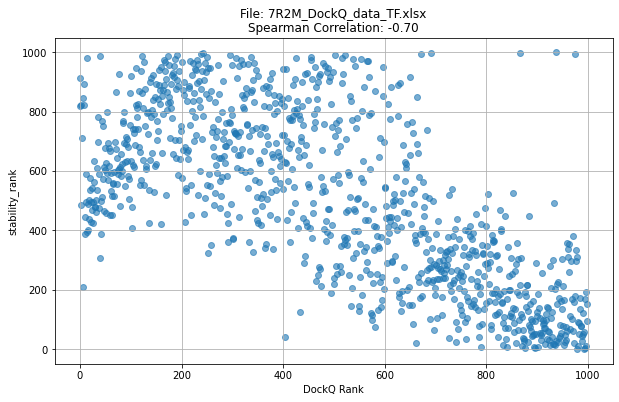

File: 7R2M_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.701973113973114



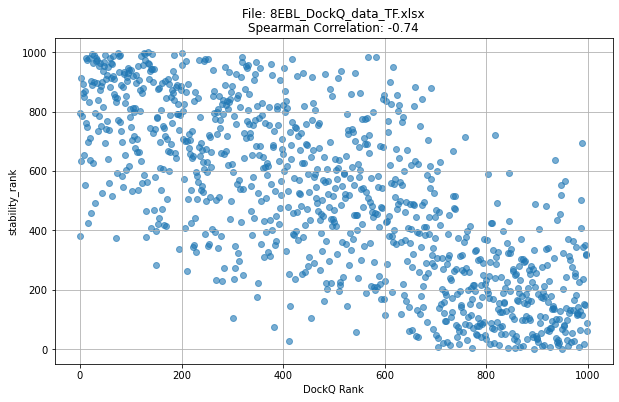

File: 8EBL_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.7428359148359149



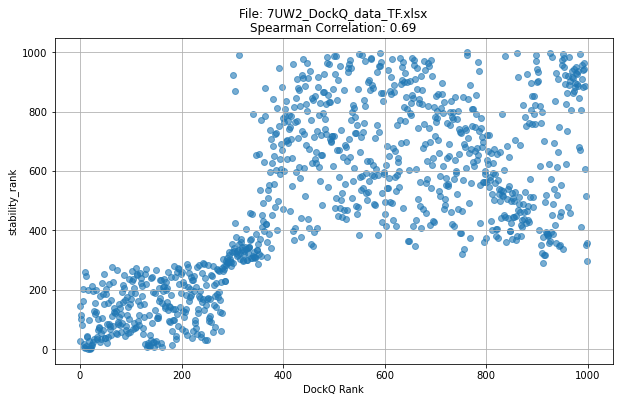

File: 7UW2_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.6865211425211426



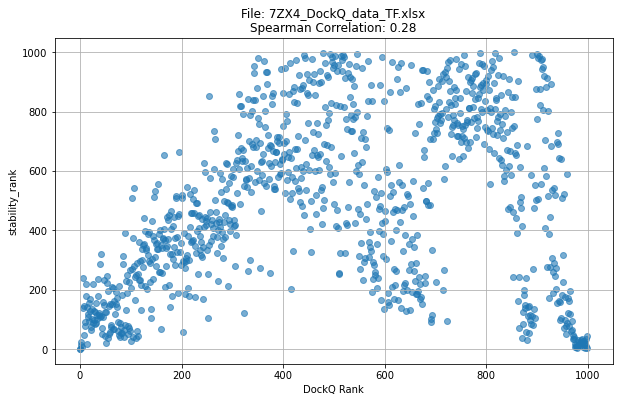

File: 7ZX4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.2767741567741568



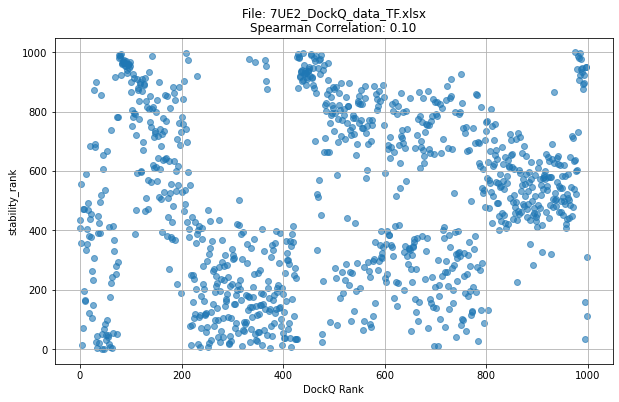

File: 7UE2_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.10282804282804285



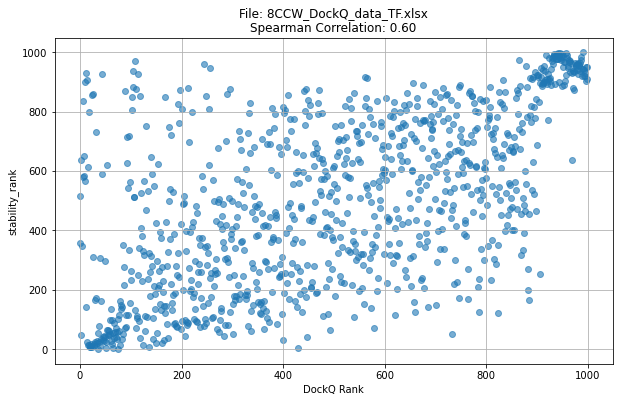

File: 8CCW_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.603912075912076



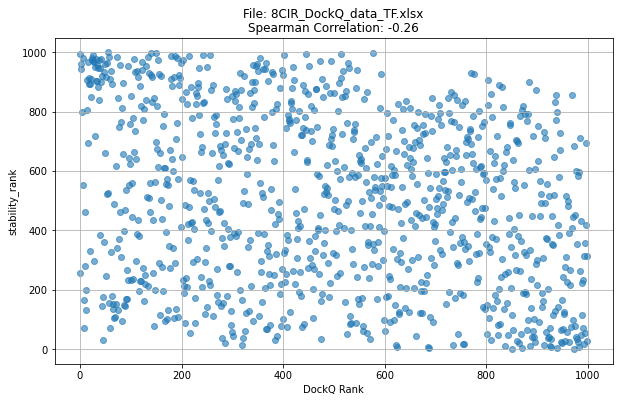

File: 8CIR_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.26343130743130744



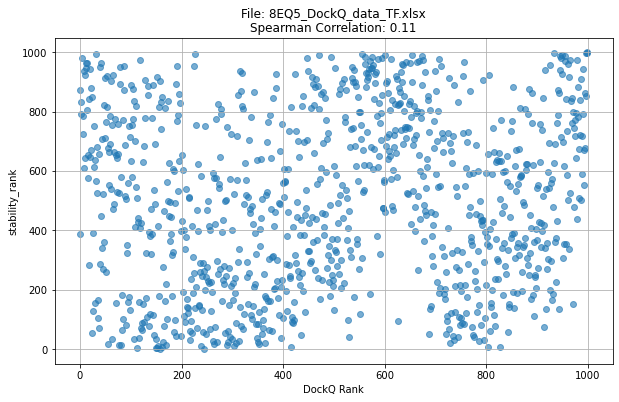

File: 8EQ5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.1121008121008121



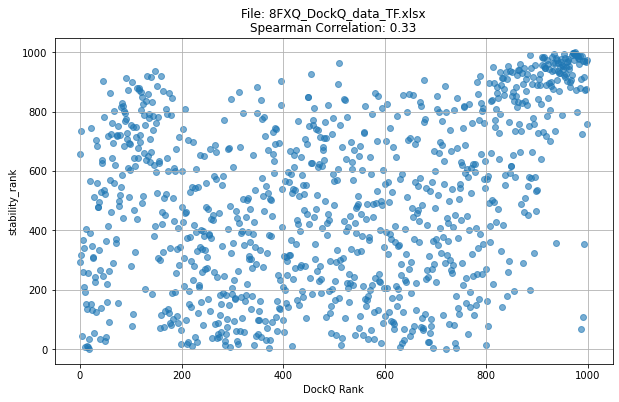

File: 8FXQ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3317314037314038



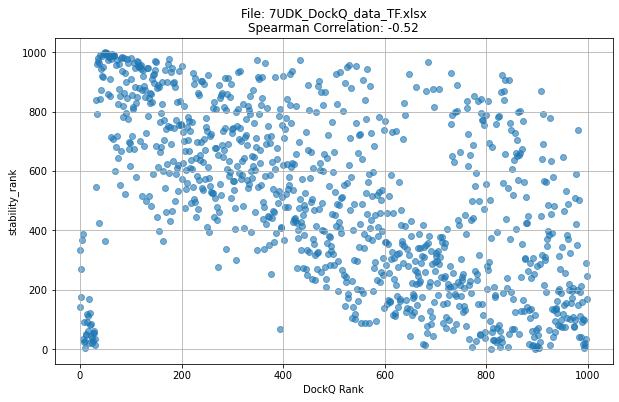

File: 7UDK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.5246354726354727



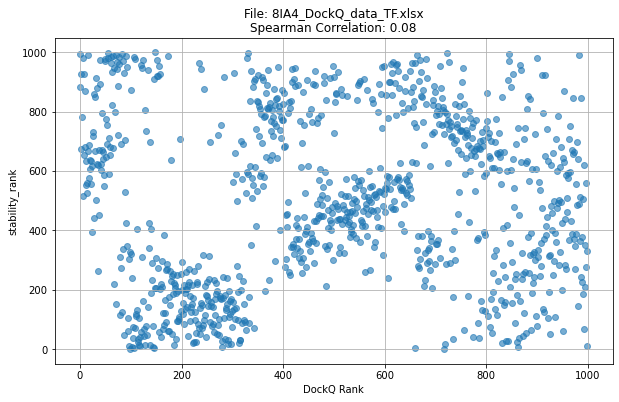

File: 8IA4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.07832313032313033



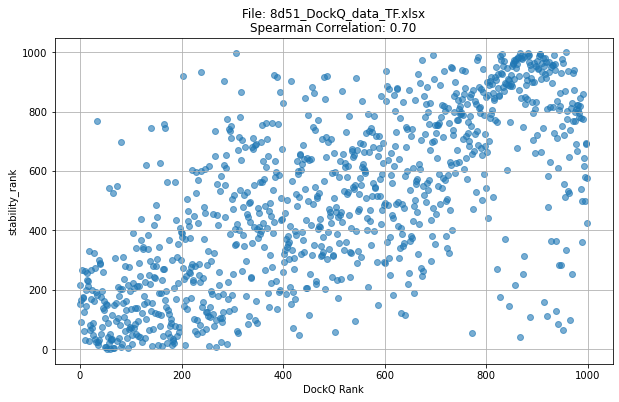

File: 8d51_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.7011253011253011



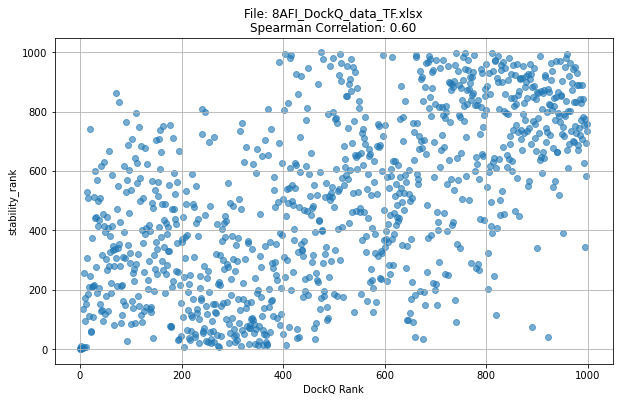

File: 8AFI_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.6001432321432323



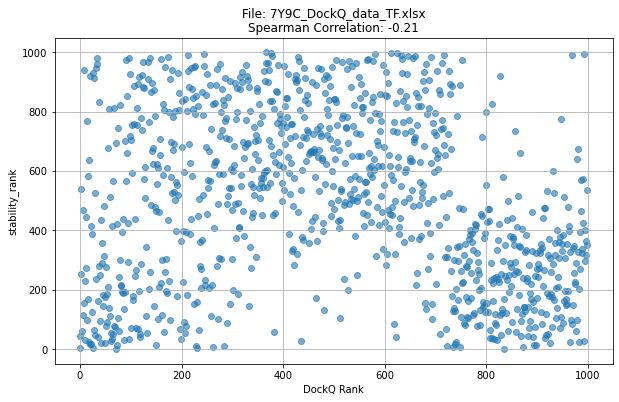

File: 7Y9C_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.20956925356925357



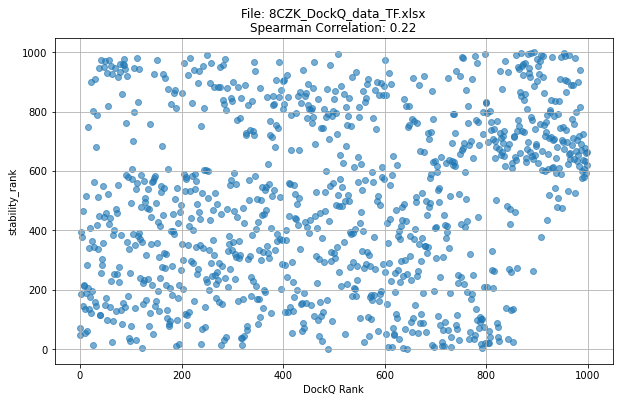

File: 8CZK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.22064590064590064



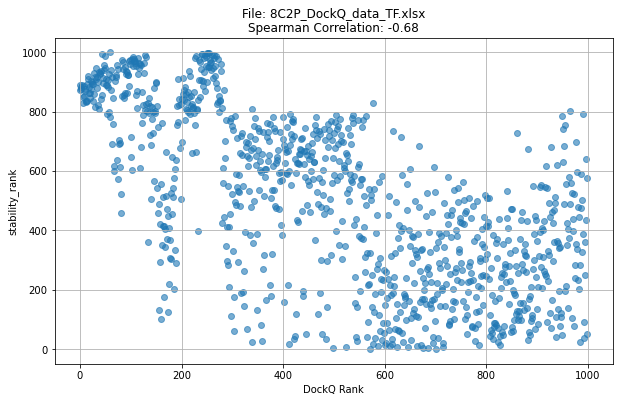

File: 8C2P_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.6754276354276355



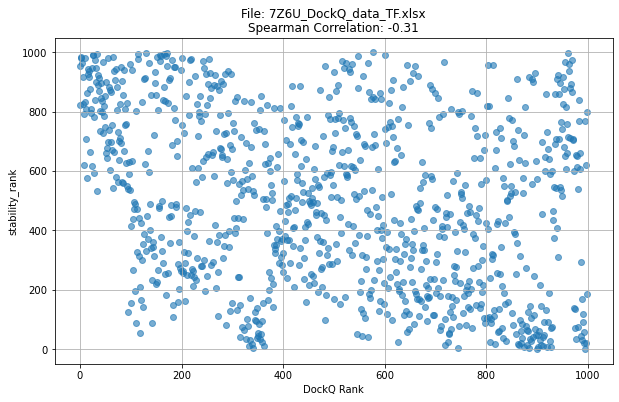

File: 7Z6U_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3064401544401545



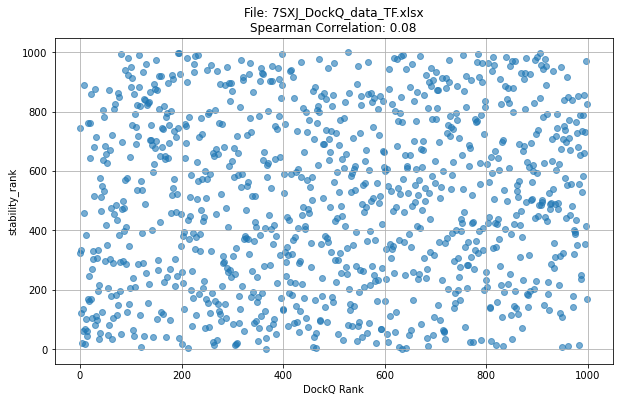

File: 7SXJ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.081997977997978



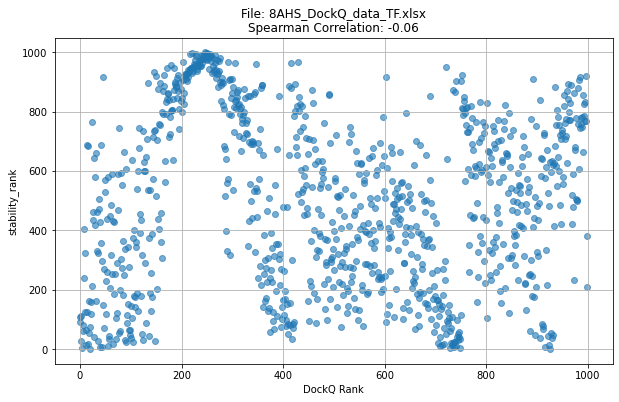

File: 8AHS_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.05634580434580436



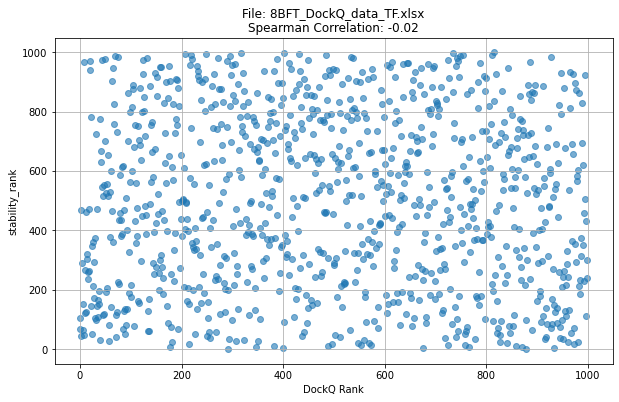

File: 8BFT_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.015794451794451794



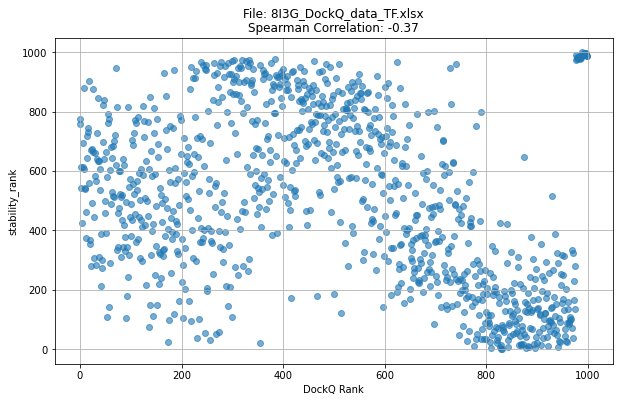

File: 8I3G_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.37364704964704964



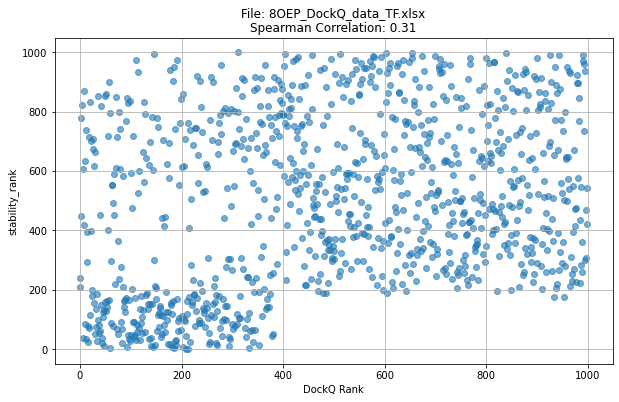

File: 8OEP_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.31180852780852786



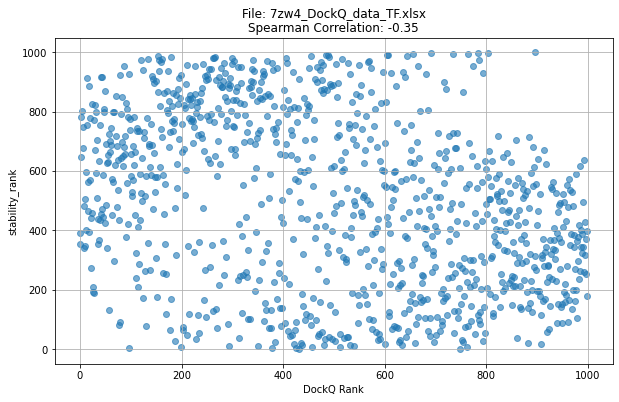

File: 7zw4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3531440451440451



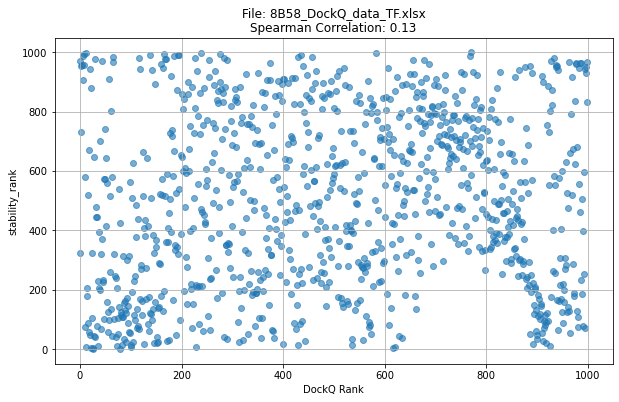

File: 8B58_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.12636333036333036



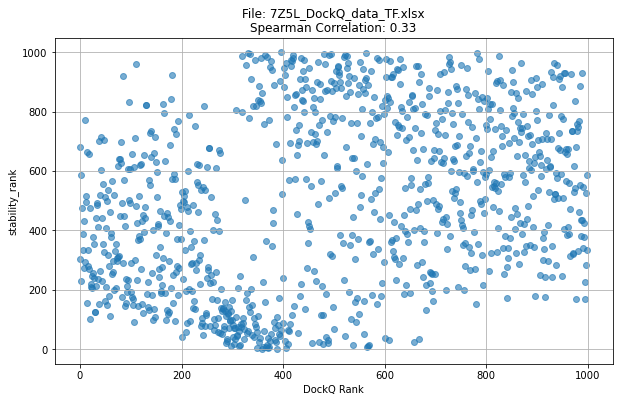

File: 7Z5L_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3253344973344973



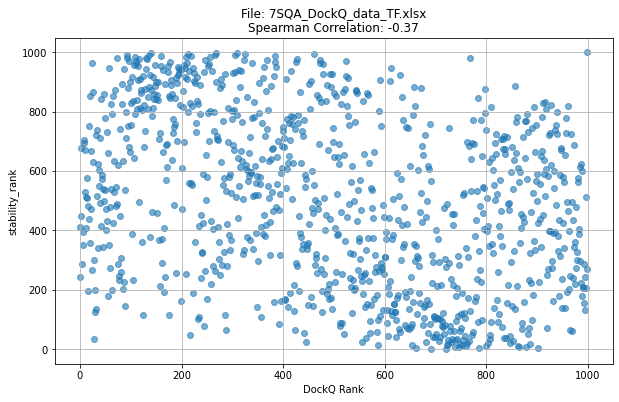

File: 7SQA_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.36811164811164815



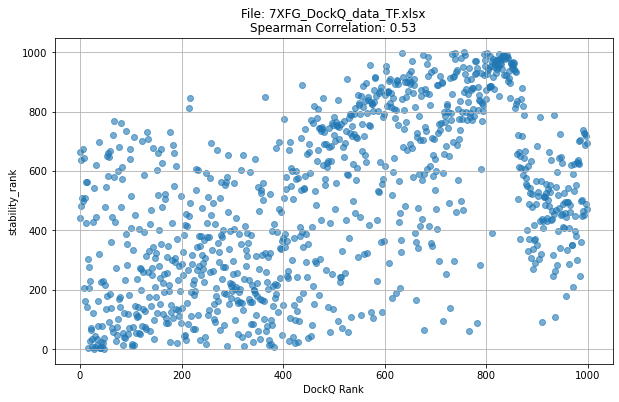

File: 7XFG_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.5340183900183901



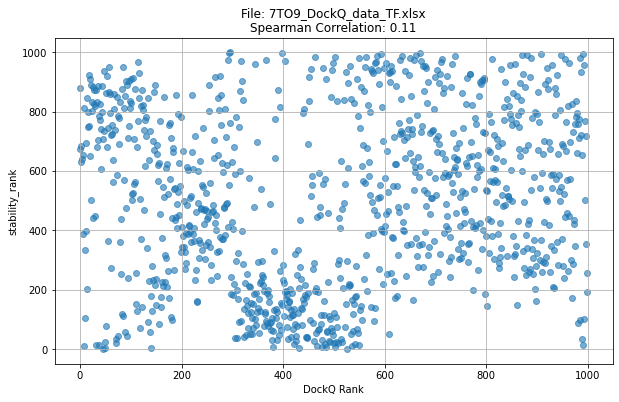

File: 7TO9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.1055981015981016



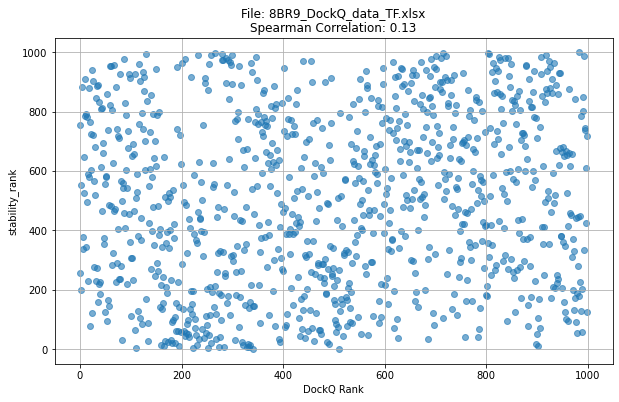

File: 8BR9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.12545154545154547



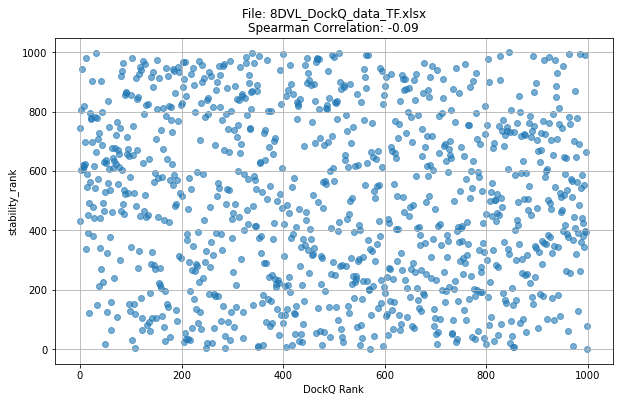

File: 8DVL_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.08566165366165367



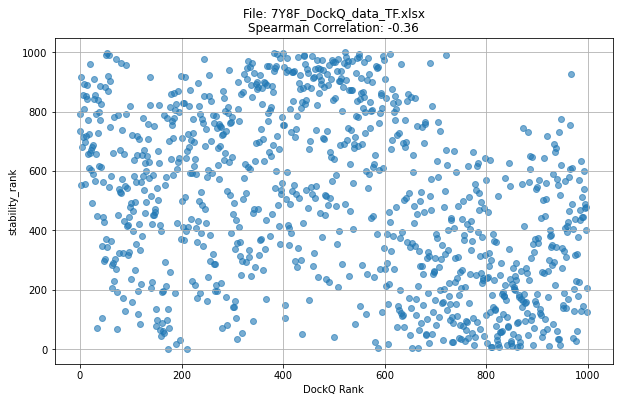

File: 7Y8F_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.35595595995596



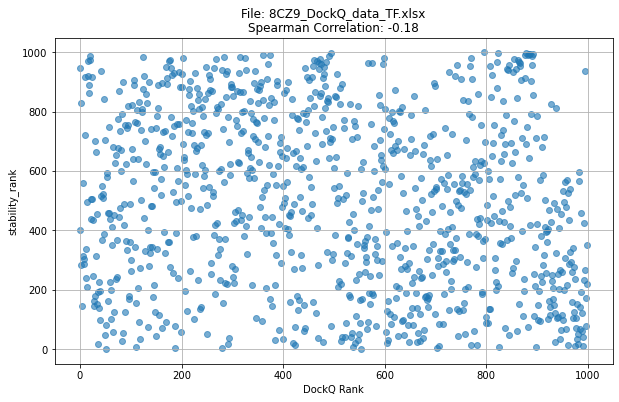

File: 8CZ9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.17941879141879144



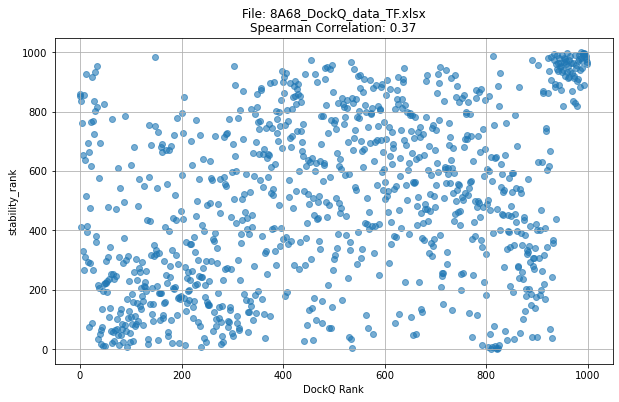

File: 8A68_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3651679251679252



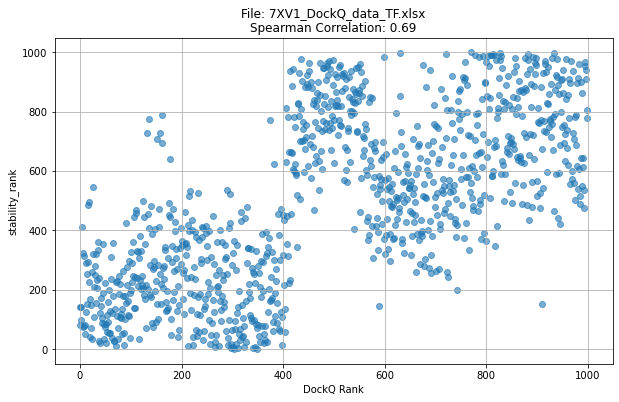

File: 7XV1_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.6883777963777964



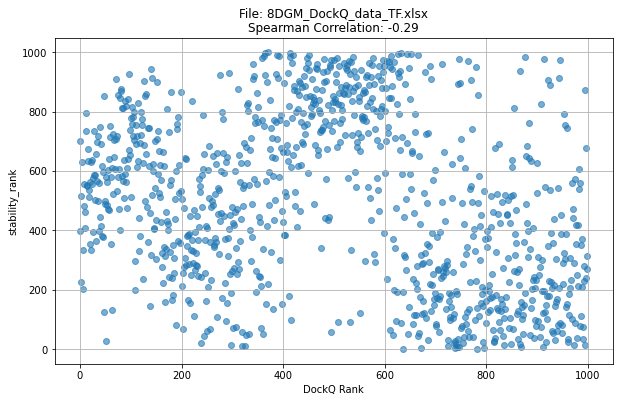

File: 8DGM_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.29071543471543476



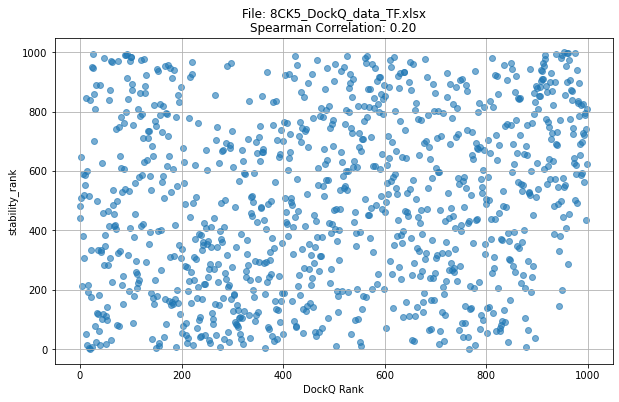

File: 8CK5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.19945720345720347



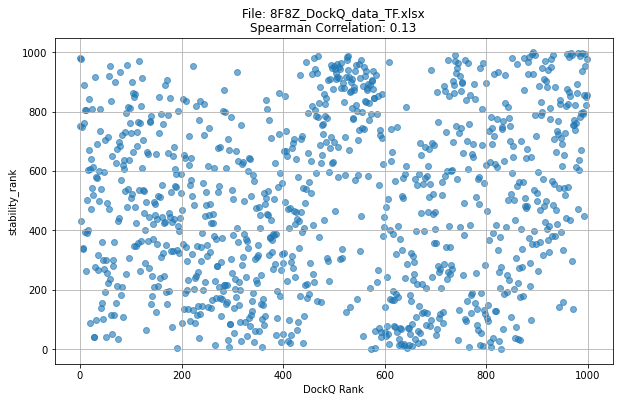

File: 8F8Z_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.13371375771375774



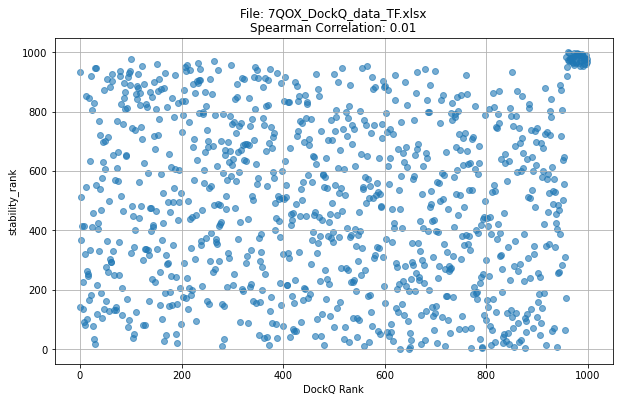

File: 7QOX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.008532884532884533



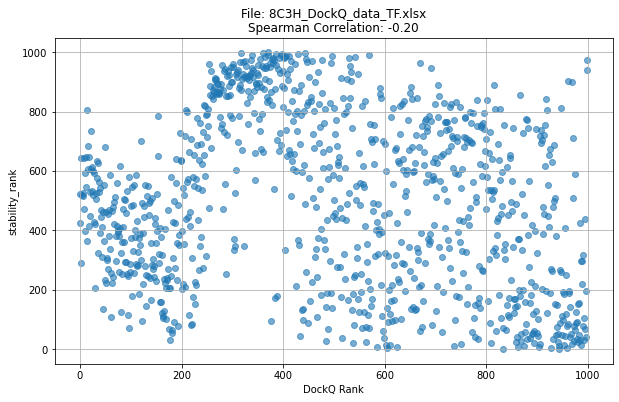

File: 8C3H_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.1961978561978562



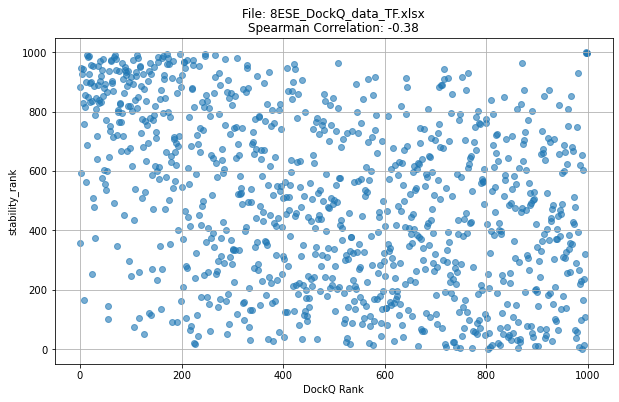

File: 8ESE_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3761101241101241



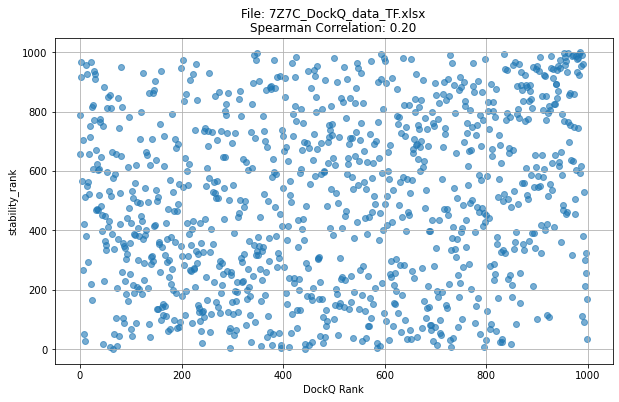

File: 7Z7C_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.1953723153723154



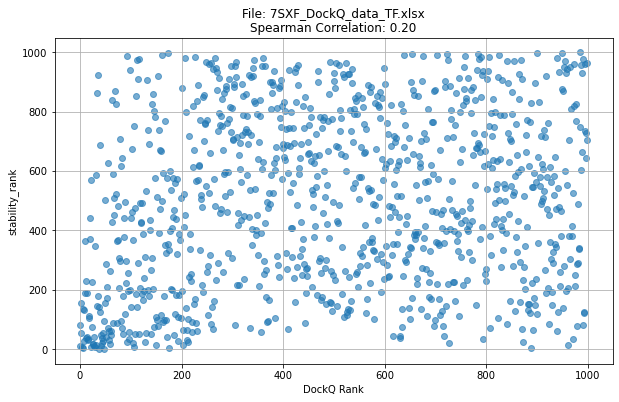

File: 7SXF_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.20101862101862103



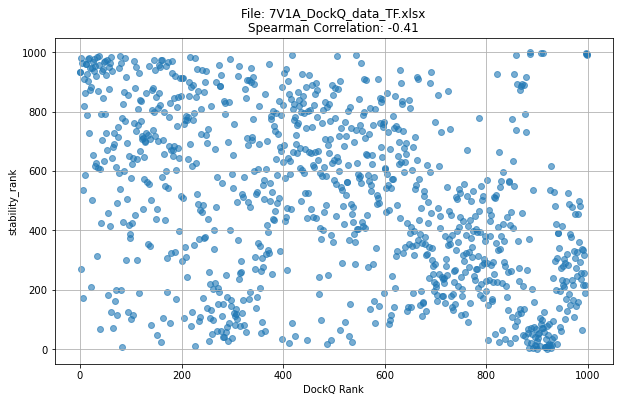

File: 7V1A_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.41179436779436784



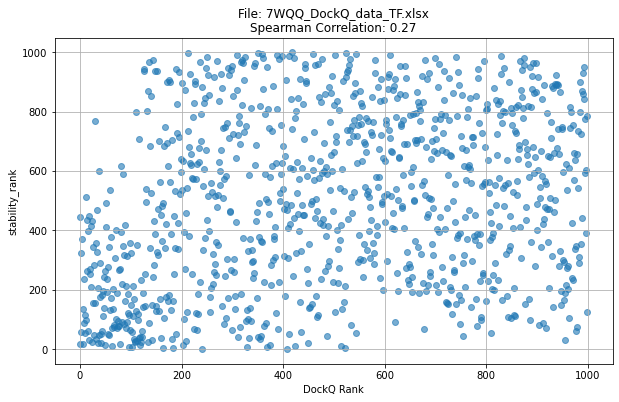

File: 7WQQ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.2721118161118162



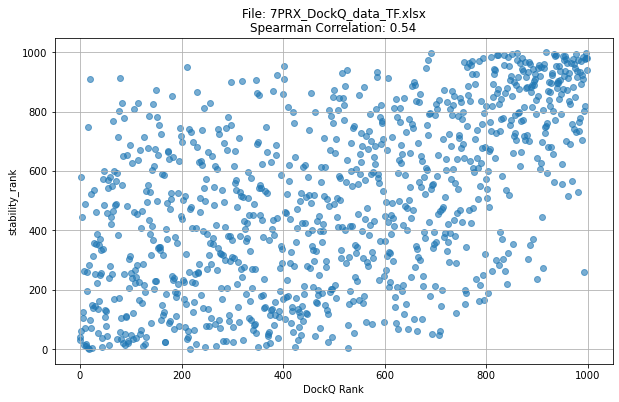

File: 7PRX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.5398750318750318



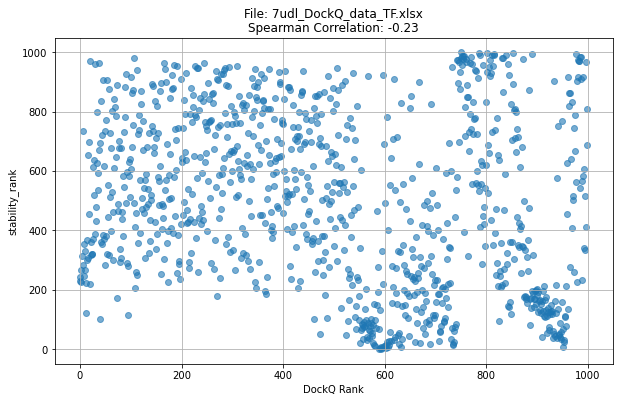

File: 7udl_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.22673103473103473



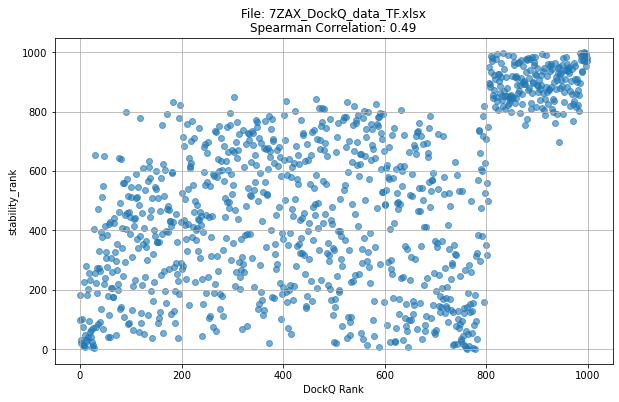

File: 7ZAX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.494971250971251



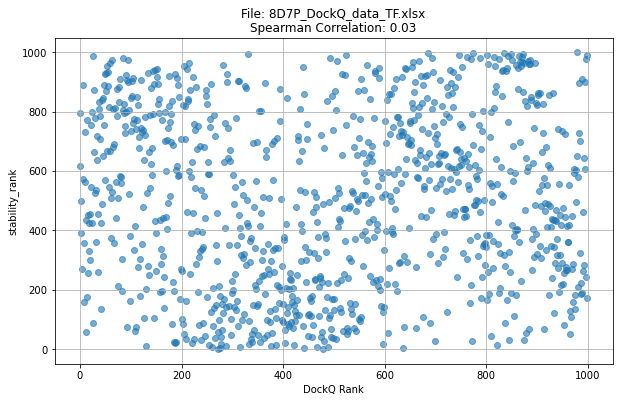

File: 8D7P_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.030534510534510537



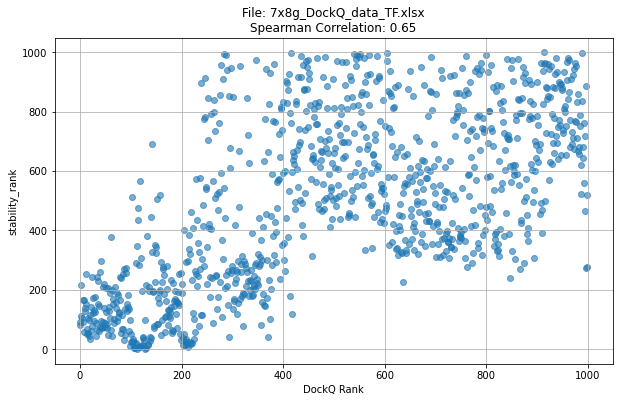

File: 7x8g_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.6453494613494615



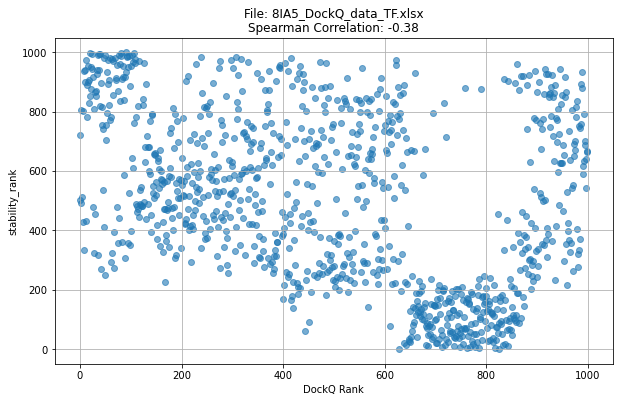

File: 8IA5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.38190812190812196



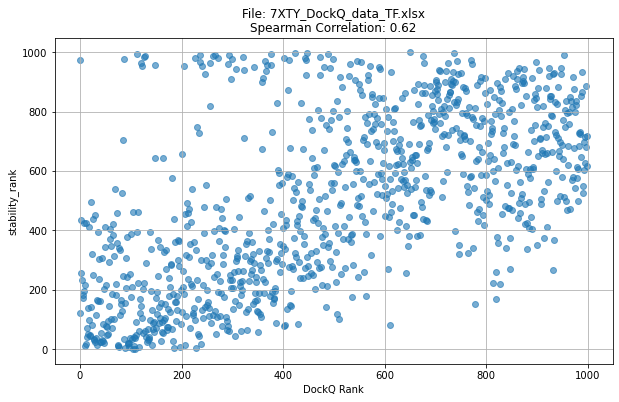

File: 7XTY_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.6241798921798922



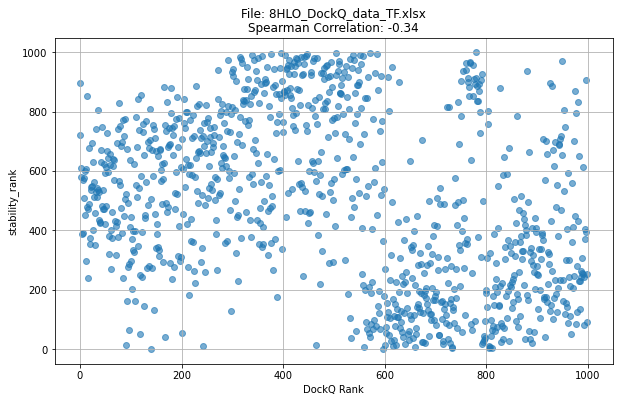

File: 8HLO_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.33527554727554726



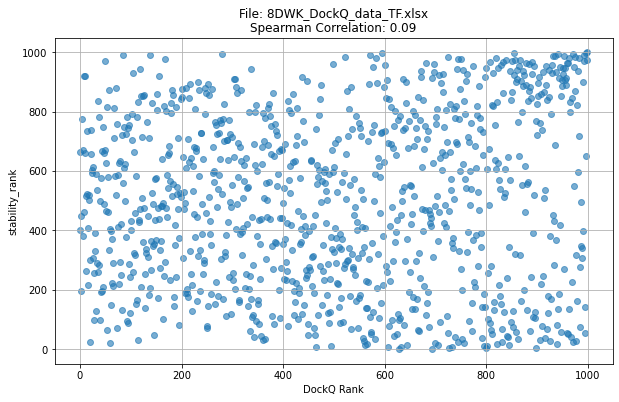

File: 8DWK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.0875938355938356



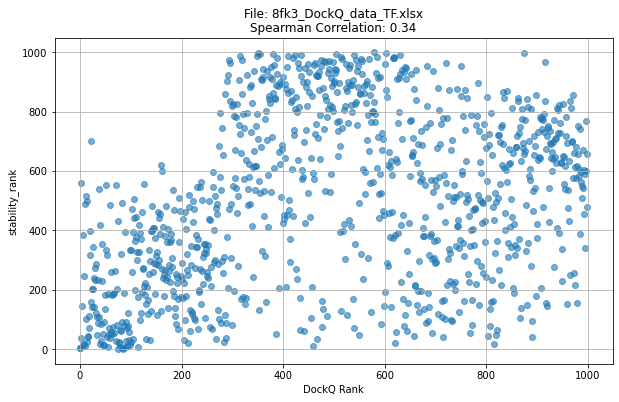

File: 8fk3_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.34211625011625013



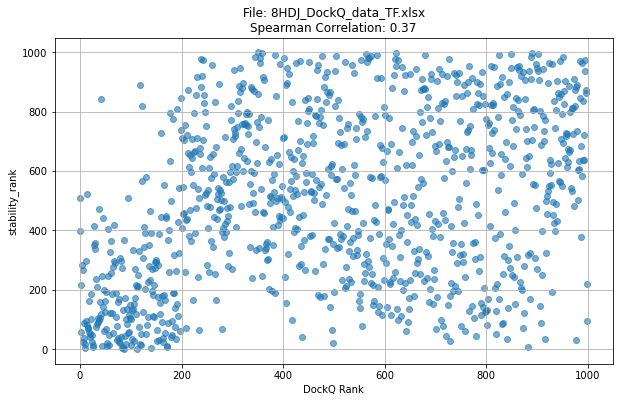

File: 8HDJ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3730635730635731



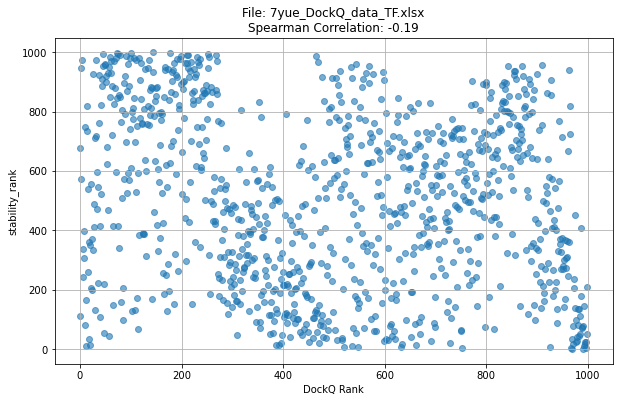

File: 7yue_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.1861041661041661



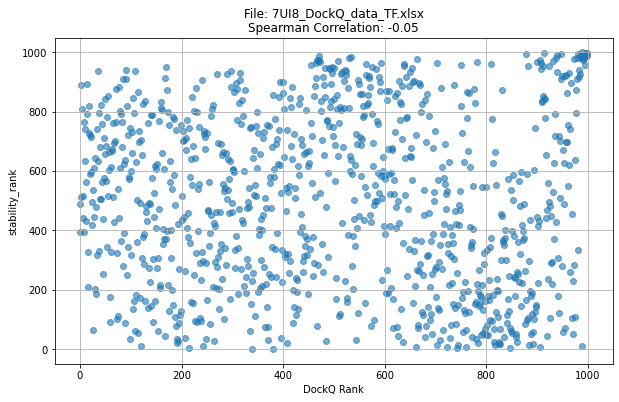

File: 7UI8_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.050529830529830524



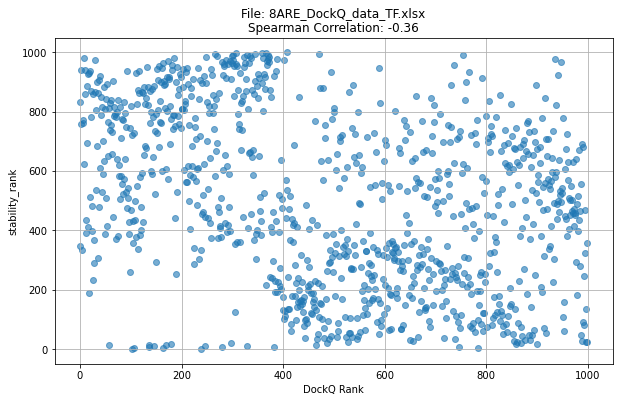

File: 8ARE_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.355011007011007



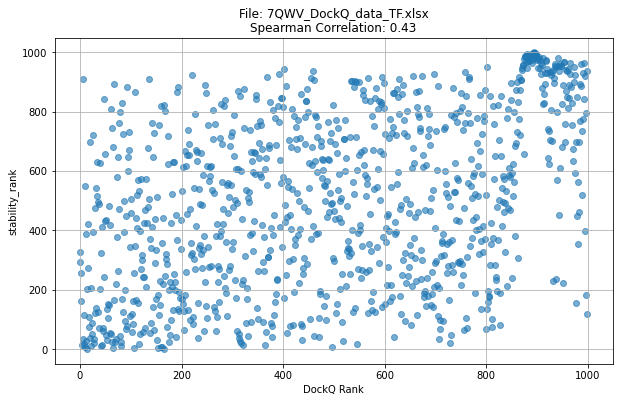

File: 7QWV_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4342860142860143



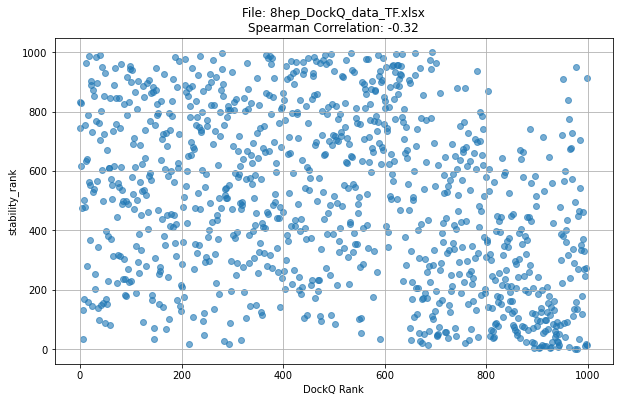

File: 8hep_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.31773110973110974

Summary of Spearman correlations saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TF_Spearman/correlations_stability_TF.xlsx


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from zipfile import BadZipFile

def process_excel_files(directory_path, output_directory):
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    correlations = []  # To store file names and their Spearman correlations
    
    for excel_file in excel_files:
        excel_file_path = os.path.join(directory_path, excel_file)
        
        try:
            xls = pd.ExcelFile(excel_file_path)
        except BadZipFile:
            print(f'Error: The file "{excel_file}" is not a valid Excel file or is corrupted.')
            continue
        except Exception as e:
            print(f'An unexpected error occurred while processing {excel_file}: {e}')
            continue
        
        if 'Foldx' not in xls.sheet_names:
            print(f'The file "{excel_file}" does not contain a "Foldx" sheet.')
            continue

        dockq_df = pd.read_excel(excel_file_path, sheet_name='Sheet')
        Foldx_df = pd.read_excel(excel_file_path, sheet_name='Foldx')
        
        Foldx_rank_column = 'stability_rank'
        alpha_to_dockq_map = dockq_df.set_index('AlphaFold Rank')['DockQ Rank'].to_dict()
        Foldx_df['DockQ Rank'] = Foldx_df['alphafold rank'].map(alpha_to_dockq_map)
        
        filtered_Foldx_df = Foldx_df.dropna(subset=['DockQ Rank'])
        
        spearman_corr, _ = spearmanr(filtered_Foldx_df[Foldx_rank_column], filtered_Foldx_df['DockQ Rank'])
        
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_Foldx_df['DockQ Rank'], filtered_Foldx_df[Foldx_rank_column], alpha=0.6)
        plt.title(f'File: {excel_file}\nSpearman Correlation: {spearman_corr:.2f}')
        plt.xlabel('DockQ Rank')
        plt.ylabel('stability_rank')
        plt.grid(True)
        plt.show()

        # Append file name and Spearman correlation to the list
        correlations.append({'File Name': excel_file, 'Spearman Correlation': spearman_corr})
        print(f'File: {excel_file}\nSpearman Correlation Coefficient: {spearman_corr}\n')
    
    # Convert list to DataFrame
    correlations_df = pd.DataFrame(correlations)
    
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Path for the new Excel file
    output_file_path = os.path.join(output_directory, 'correlations_stability_TF.xlsx')
    
    # Save DataFrame to an Excel file
    correlations_df.to_excel(output_file_path, index=False)
    print(f'Summary of Spearman correlations saved to {output_file_path}')

# Example usage
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/stability_TF'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TF_Spearman'
process_excel_files(directory_path, output_directory)



In [7]:
import pandas as pd

def calculate_positive_negative_percentages_and_average(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path)
    
    # Count the total number of entries
    total_entries = len(data['Spearman Correlation'])
    
    # Count the number of positive and negative Foldx_Spearman Correlation values
    positive_count = data[data['Spearman Correlation'] > 0].shape[0]
    negative_count = data[data['Spearman Correlation'] < 0].shape[0]
    
    # Calculate percentages
    positive_percentage = (positive_count / total_entries) * 100
    negative_percentage = (negative_count / total_entries) * 100
    
    # Calculate the average of Foldx_Spearman Correlation values
    average_correlation = data['Spearman Correlation'].mean()
    
    return positive_percentage, negative_percentage, average_correlation

# Example usage
file_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TF_Spearman/correlations_stability_TF.xlsx'  # Replace with your actual file path
positive_percentage, negative_percentage, average_correlation = calculate_positive_negative_percentages_and_average(file_path)
print(f"Positive Foldx_Spearman Correlation: {positive_percentage:.2f}%")
print(f"Negative Foldx_Spearman Correlation: {negative_percentage:.2f}%")
print(f"Average Foldx_Spearman Correlation: {average_correlation:.2f}")


Positive Foldx_Spearman Correlation: 56.67%
Negative Foldx_Spearman Correlation: 43.33%
Average Foldx_Spearman Correlation: 0.04


In [8]:
import os
import pandas as pd

# Directory containing the Excel files
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/stability_TF'

# Initialize a list to store the results
results = []

# List all Excel files in the directory
excel_files = [file for file in os.listdir(directory_path) if file.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    xls = pd.ExcelFile(file_path)

    # Extract pdb_id from file name
    pdb_id = file_name.split('_')[0]

    # Load data from "Foldx" sheet
    foldx_df = pd.read_excel(file_path, sheet_name='Foldx')
    structure_name_for_rank_zero = foldx_df[foldx_df['stability_rank'] == 0]['Unnamed: 0'].iloc[0].replace('_clean.pdb', '')

    # Load data from "Sheet" sheet
    sheet_df = pd.read_excel(file_path, sheet_name='Sheet')

    # Highest DockQ score
    highest_dockq_score = sheet_df['DockQ'].max()

    # DockQ score for the structure from Foldx
    highest_foldx_dockq_score = sheet_df[sheet_df['File Name'].str.contains(structure_name_for_rank_zero)]['DockQ'].max()

    # Calculate Loss
    score_Loss = highest_dockq_score - highest_foldx_dockq_score

    # Append results
    results.append([pdb_id, highest_dockq_score, highest_foldx_dockq_score, score_Loss])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['File Name', 'DockQ', 'Foldx/Stability ranked', 'Loss'])

# Save the results into a new Excel file
output_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TF_Loss/Foldx_stability_TF.xlsx'
results_df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")



Results have been saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TF_Loss/Foldx_stability_TF.xlsx


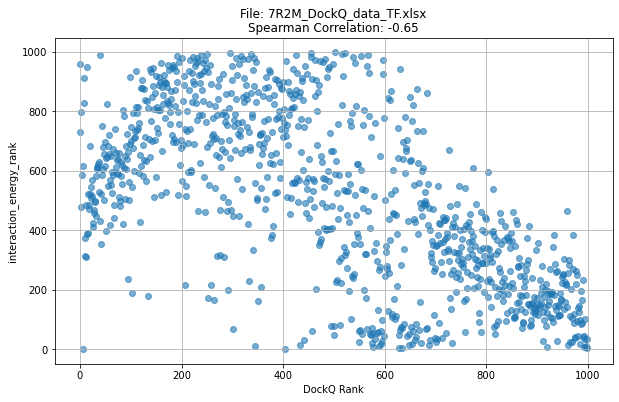

File: 7R2M_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.6534007233686592



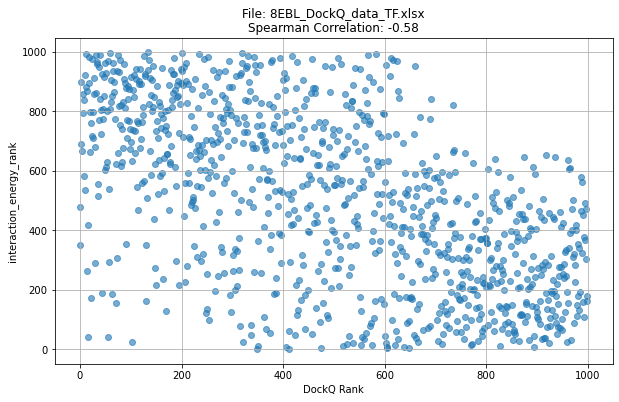

File: 8EBL_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.5800675585405043



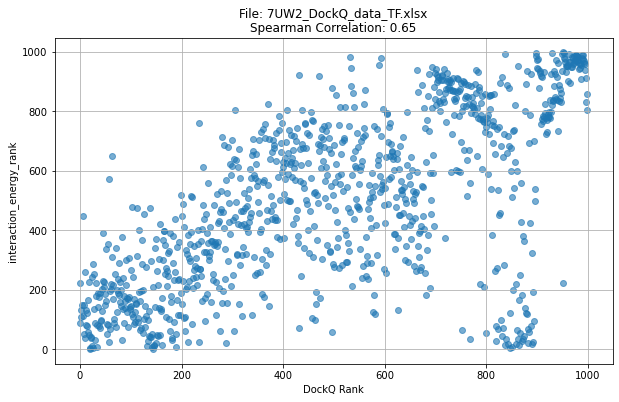

File: 7UW2_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.6520784030523509



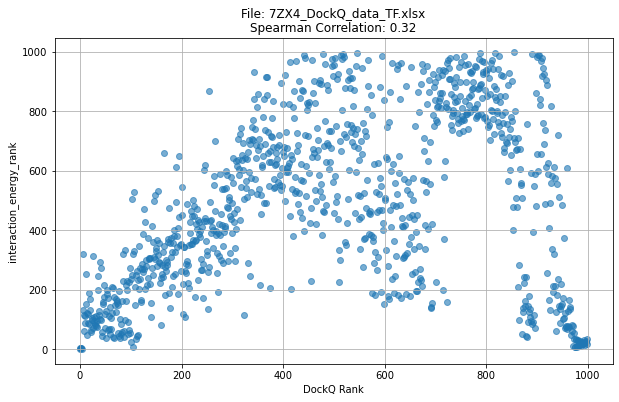

File: 7ZX4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.32456840407541804



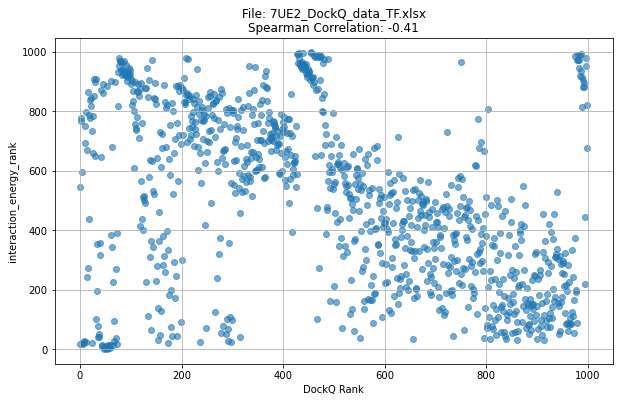

File: 7UE2_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.4114196200208224



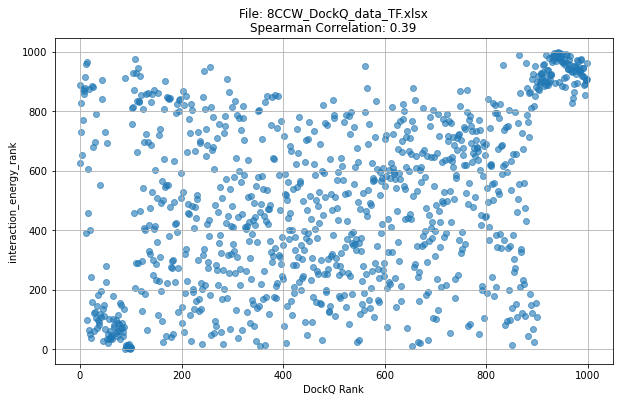

File: 8CCW_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.38682495320972266



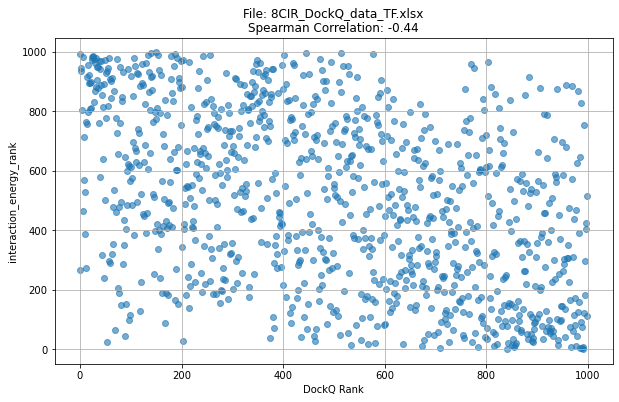

File: 8CIR_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.4421271010489447



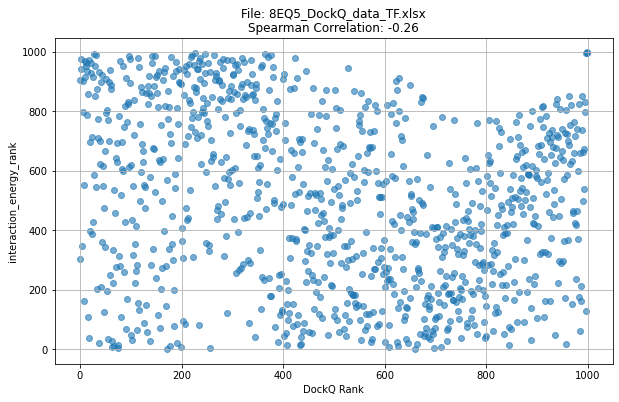

File: 8EQ5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.2612745009538597



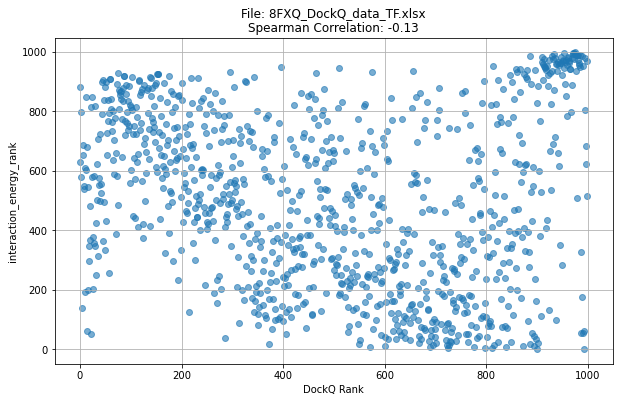

File: 8FXQ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.133689577352904



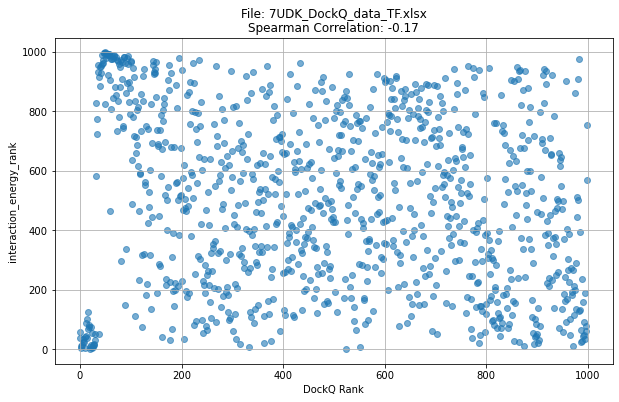

File: 7UDK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.17144612347818755



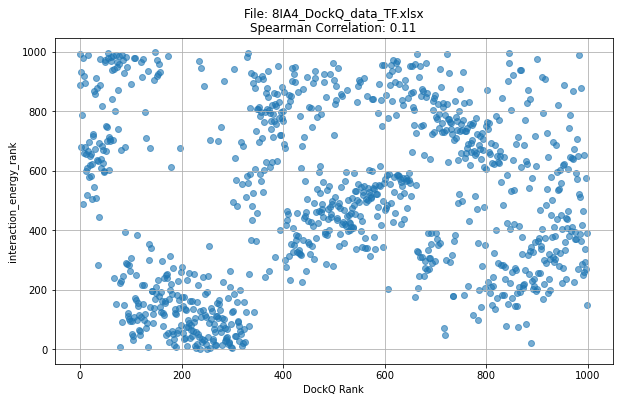

File: 8IA4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.10722784909157654



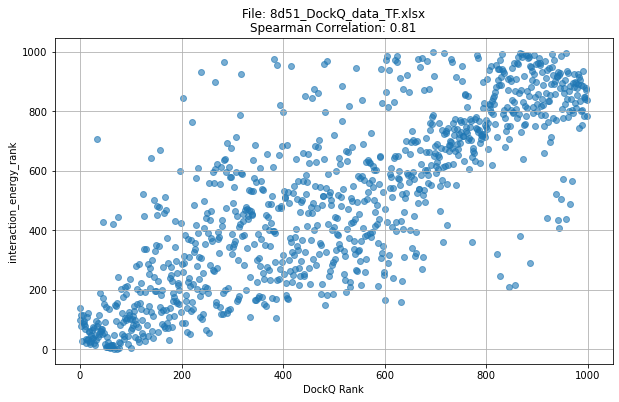

File: 8d51_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.8104461656044822



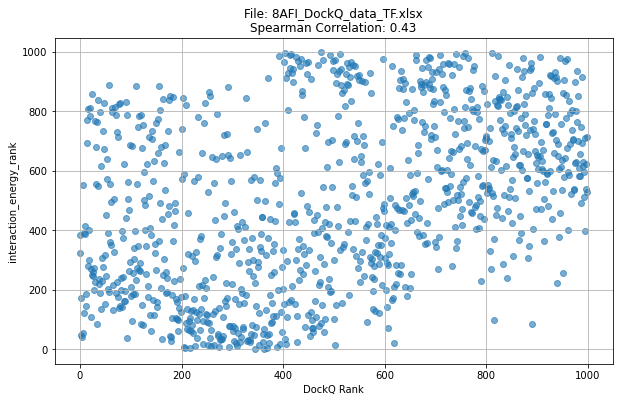

File: 8AFI_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4341101903506712



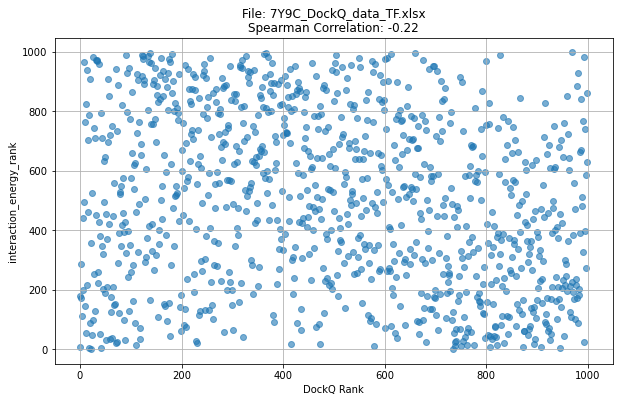

File: 7Y9C_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.22089018878598035



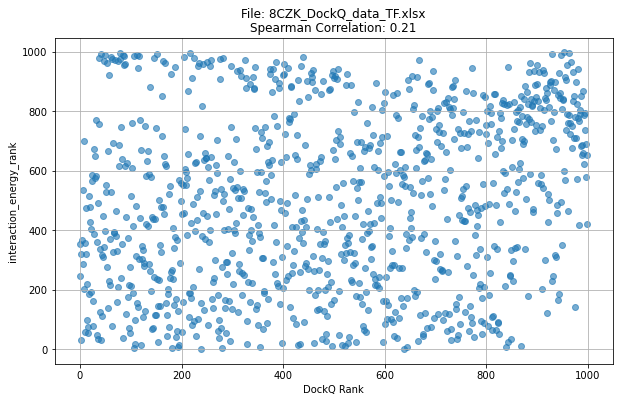

File: 8CZK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.2116020389126601



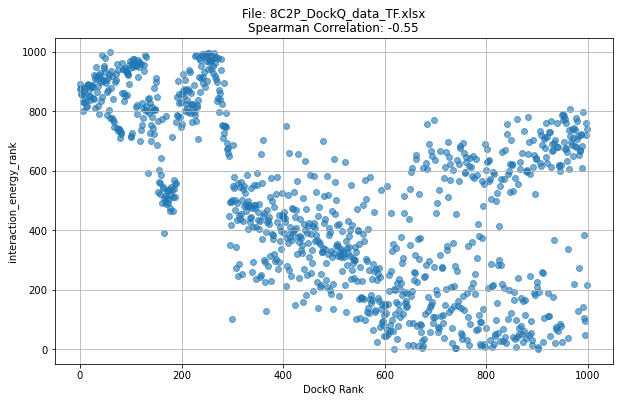

File: 8C2P_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.5515614412007196



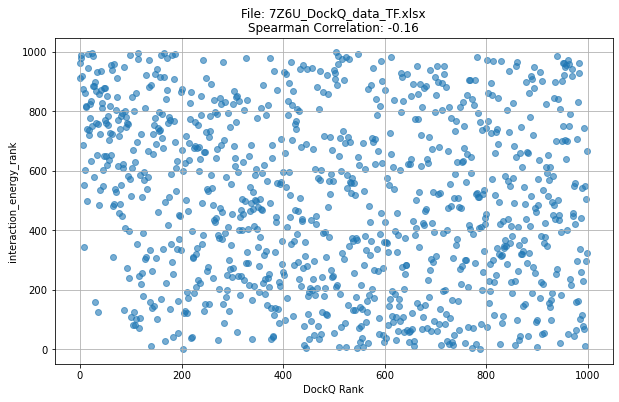

File: 7Z6U_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.16341399916951016



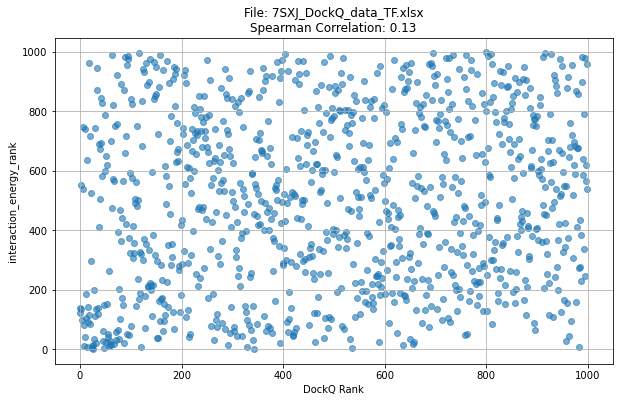

File: 7SXJ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.13096499304916137



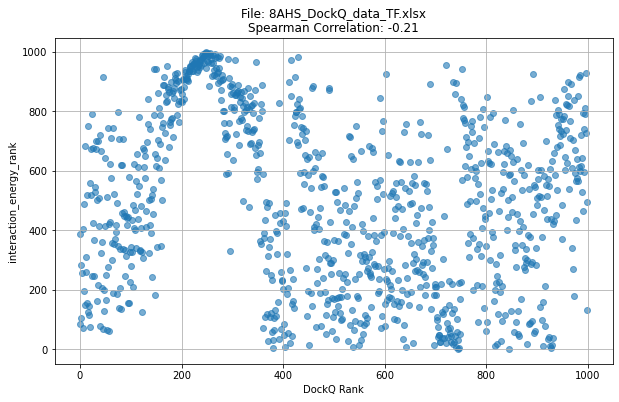

File: 8AHS_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.21027021008984934



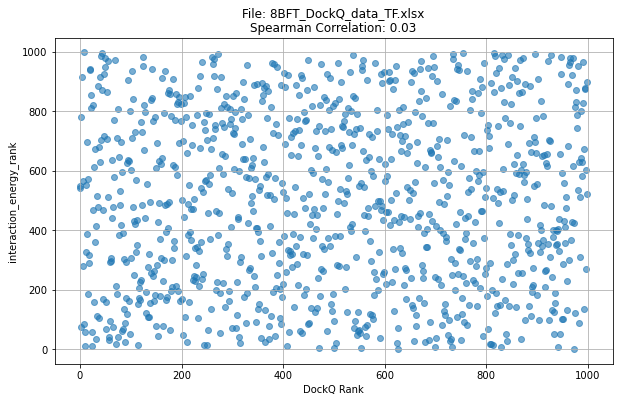

File: 8BFT_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.030150703810022442



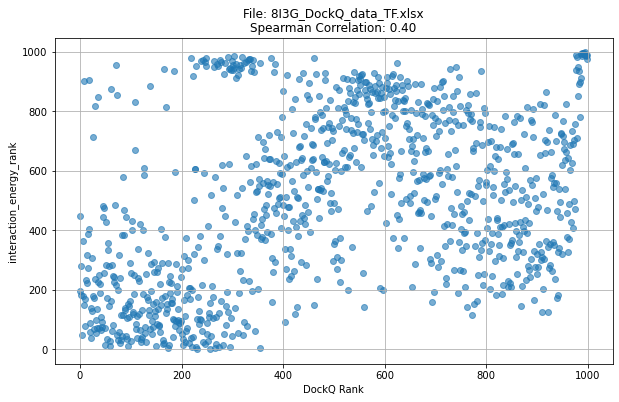

File: 8I3G_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4024456721250308



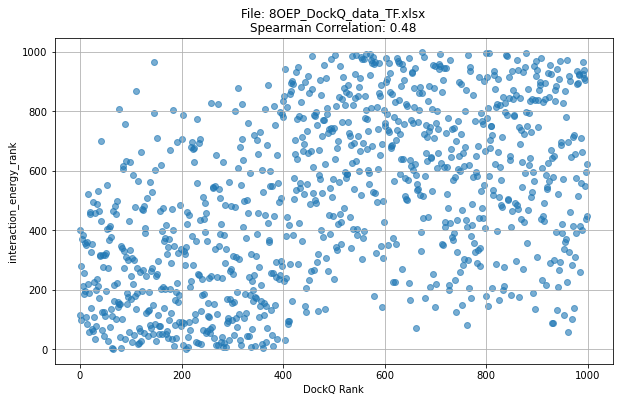

File: 8OEP_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.48267350316248103



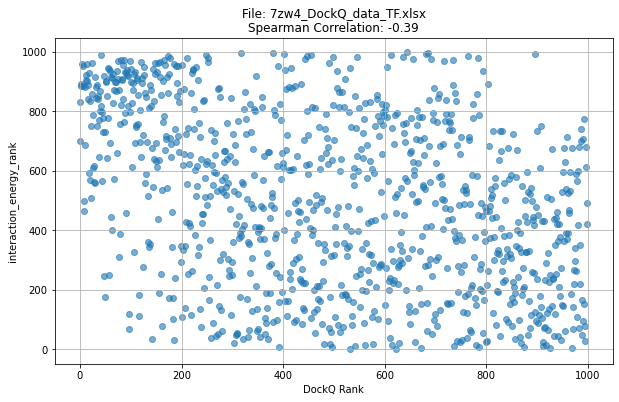

File: 7zw4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3928713643503222



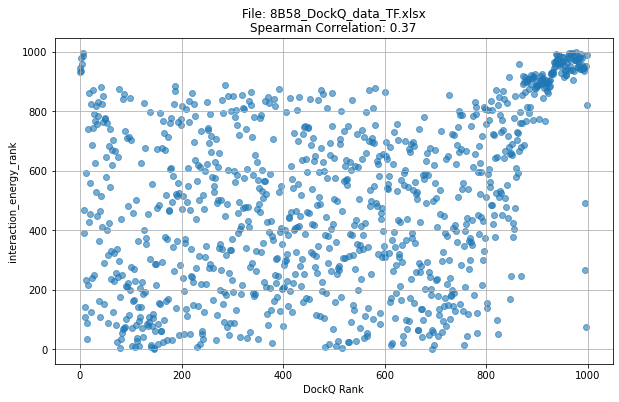

File: 8B58_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.366027827426625



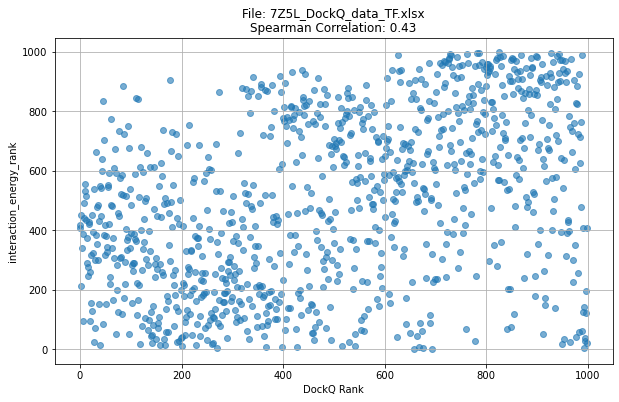

File: 7Z5L_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4290407361269084



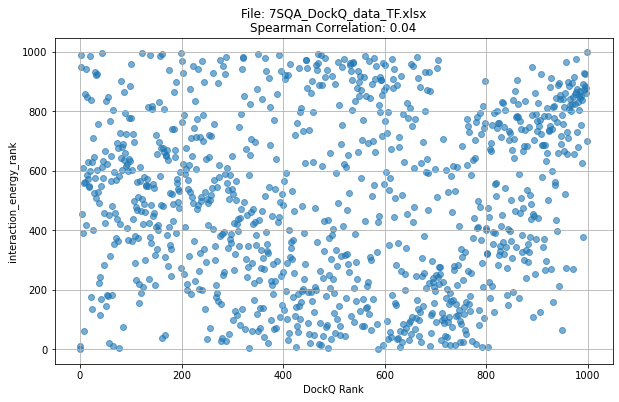

File: 7SQA_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.042667220326538954



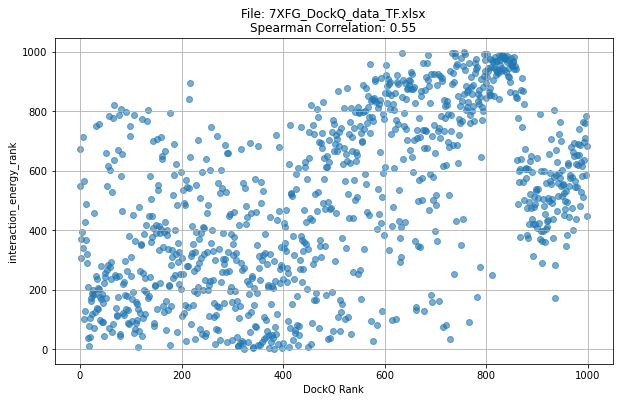

File: 7XFG_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.549018890634121



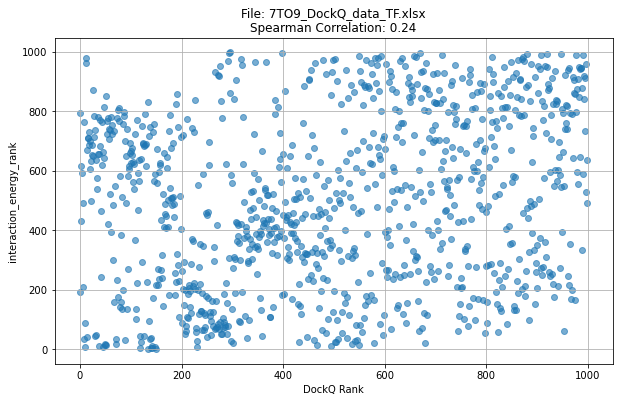

File: 7TO9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.2423137566424139



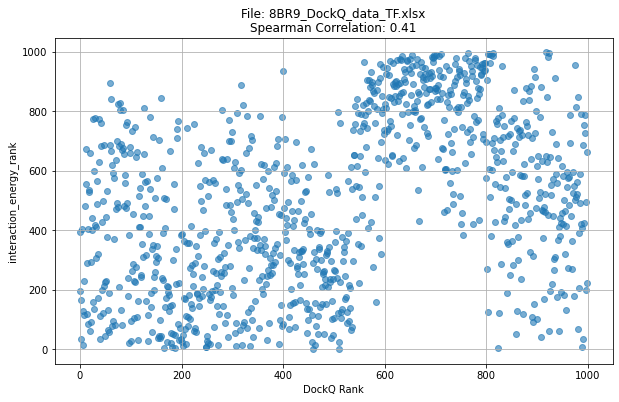

File: 8BR9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4065258565178404



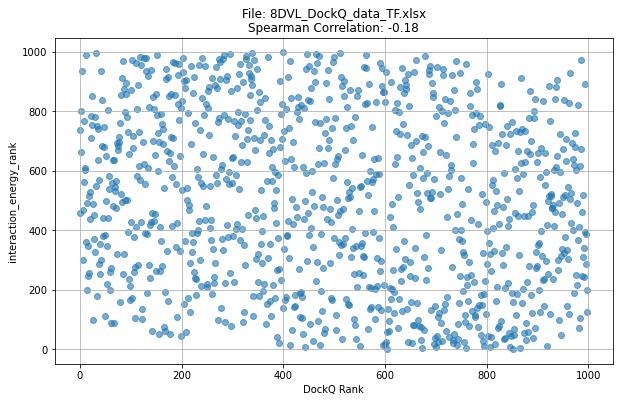

File: 8DVL_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.1819458978016092



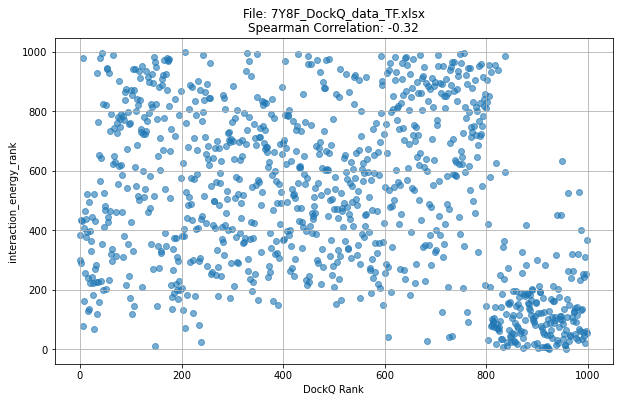

File: 7Y8F_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.31816338984274856



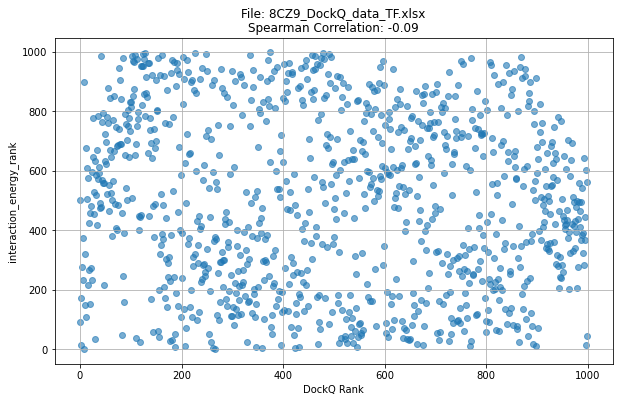

File: 8CZ9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.09411324751605311



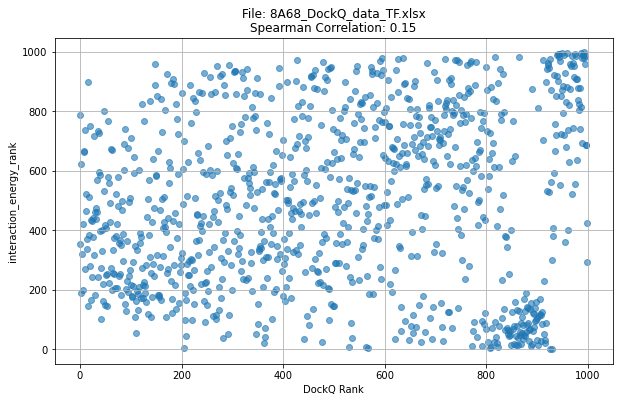

File: 8A68_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.1527714889237935



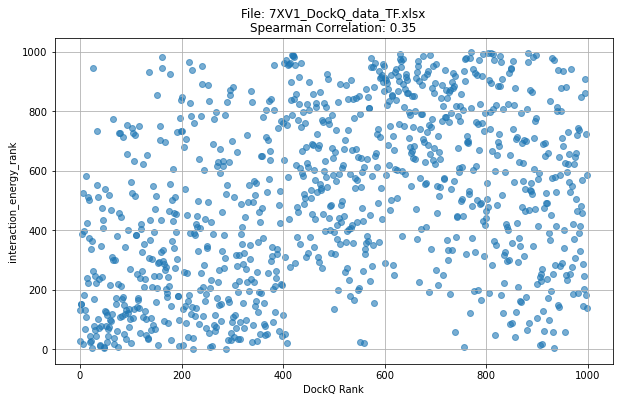

File: 7XV1_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.35286330017392137



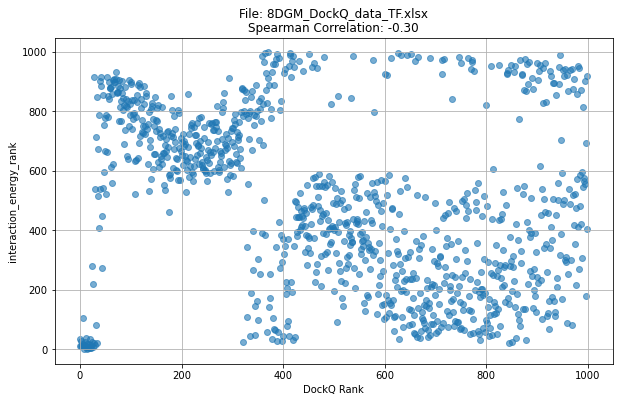

File: 8DGM_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.2973952830586096



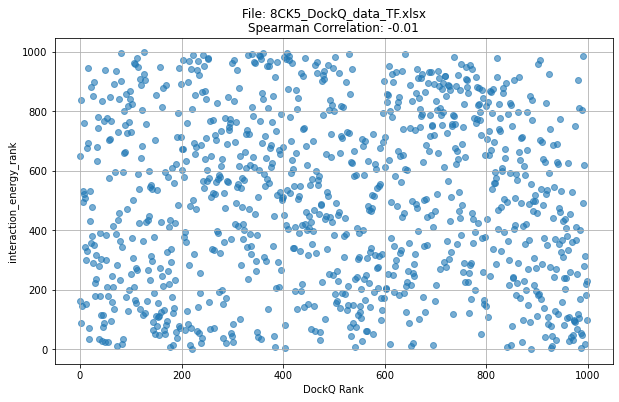

File: 8CK5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.010844319269168966



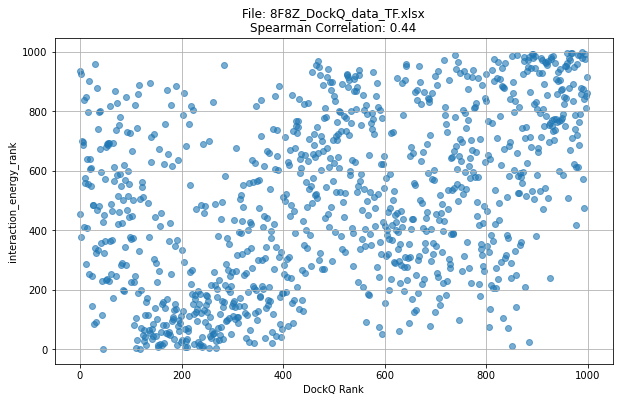

File: 8F8Z_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4392510787340447



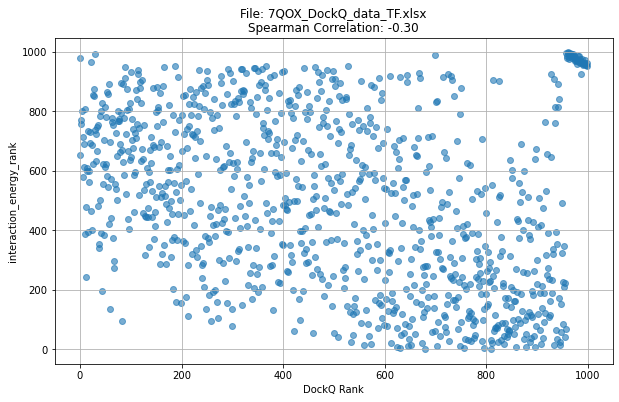

File: 7QOX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.2992606233487996



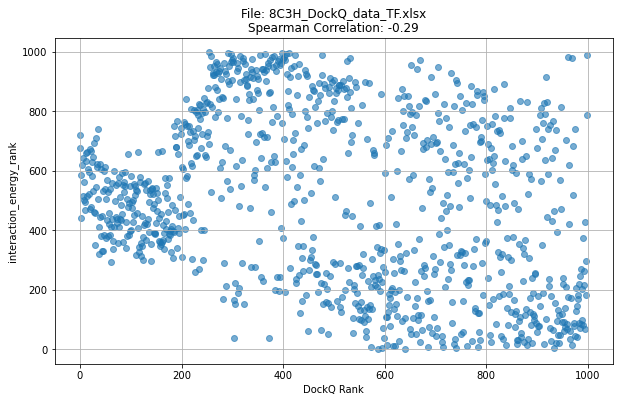

File: 8C3H_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.29448464496560683



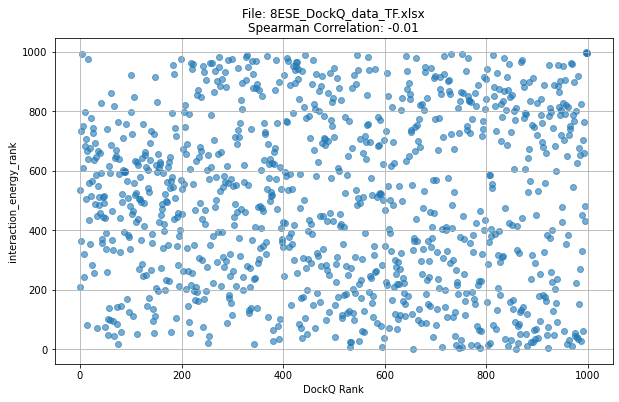

File: 8ESE_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.006012204589358897



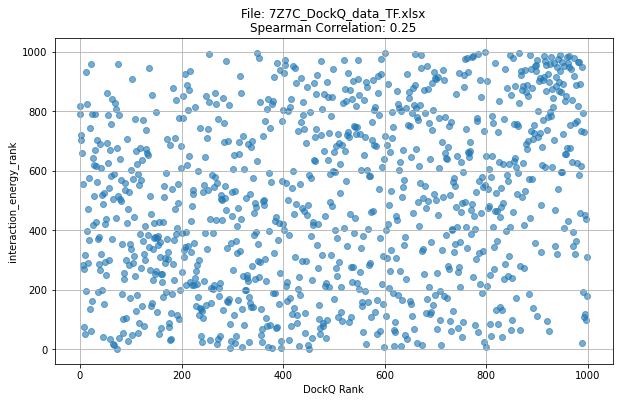

File: 7Z7C_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.24795841532915677



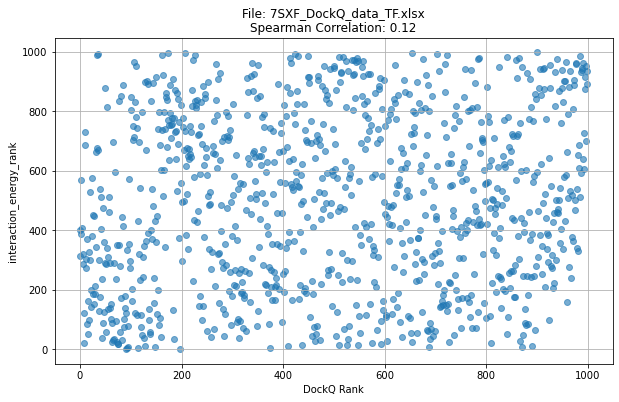

File: 7SXF_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.11646667509192558



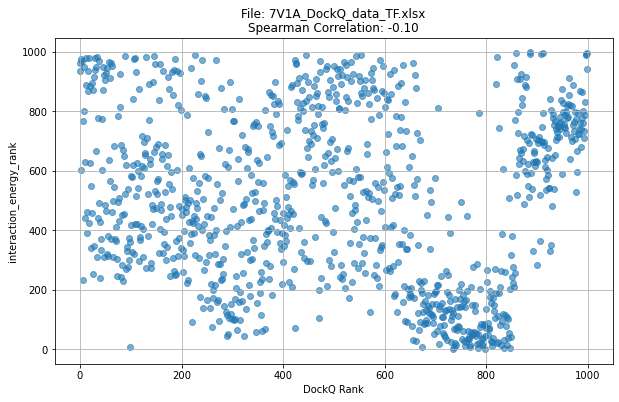

File: 7V1A_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.10080473258829971



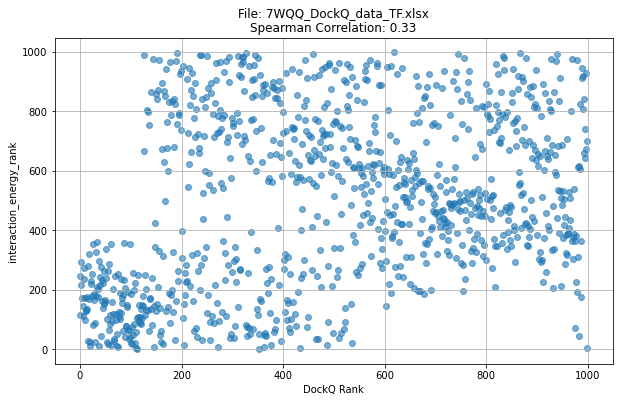

File: 7WQQ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3278184477062232



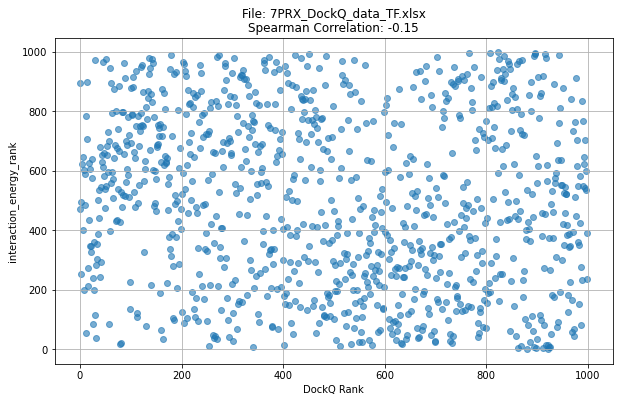

File: 7PRX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.14814894654173208



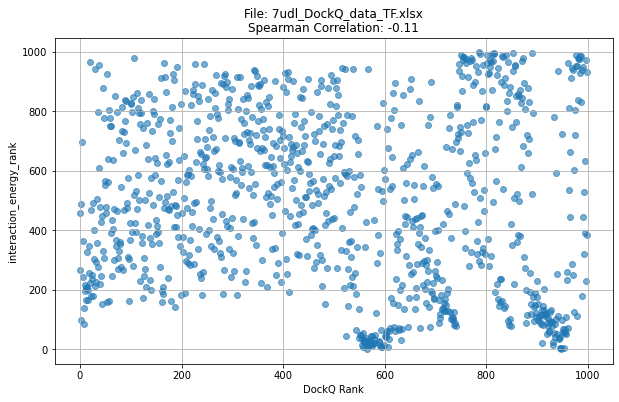

File: 7udl_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.10855570600660779



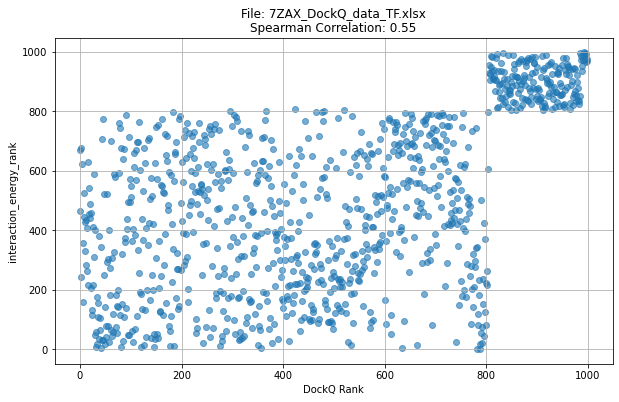

File: 7ZAX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.552673635559407



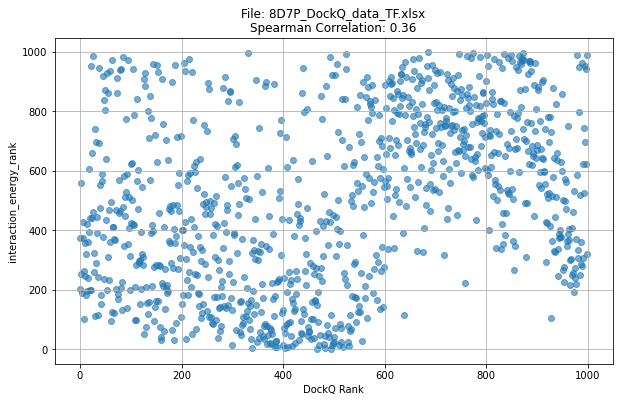

File: 8D7P_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3582601599595587



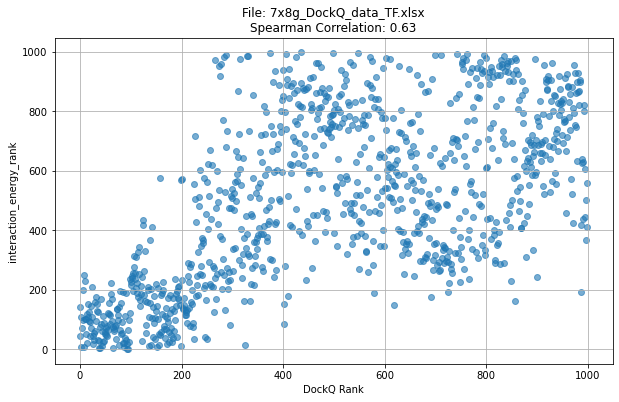

File: 7x8g_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.6305942575842375



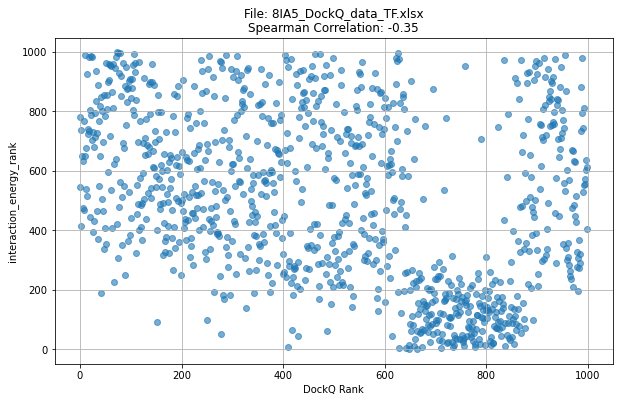

File: 8IA5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.34966731059717027



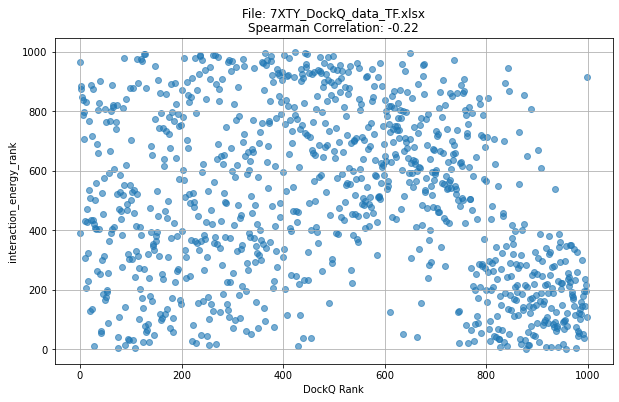

File: 7XTY_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.22499384354294172



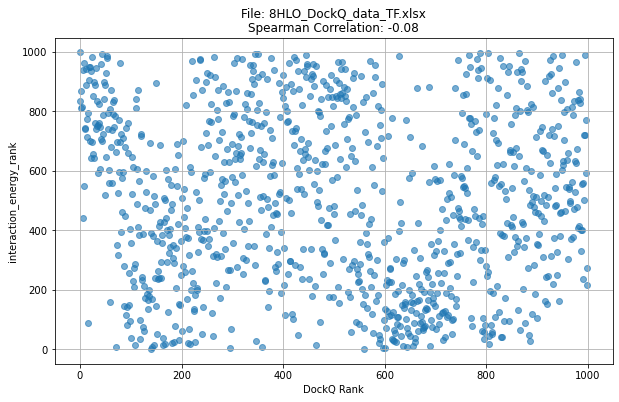

File: 8HLO_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.08260215325545985



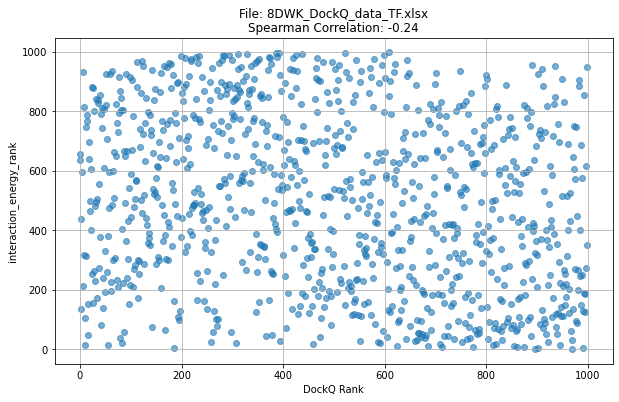

File: 8DWK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.23757770195044742



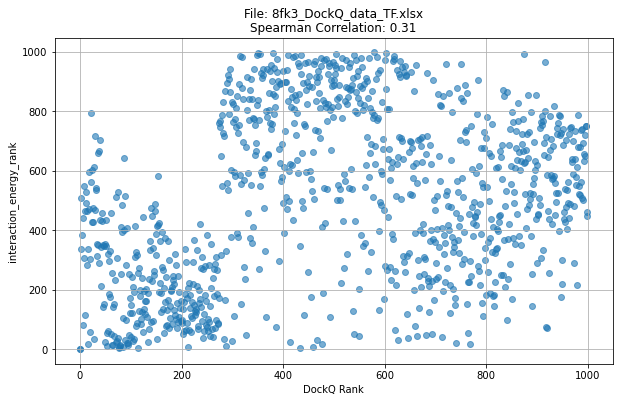

File: 8fk3_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.31475508374105565



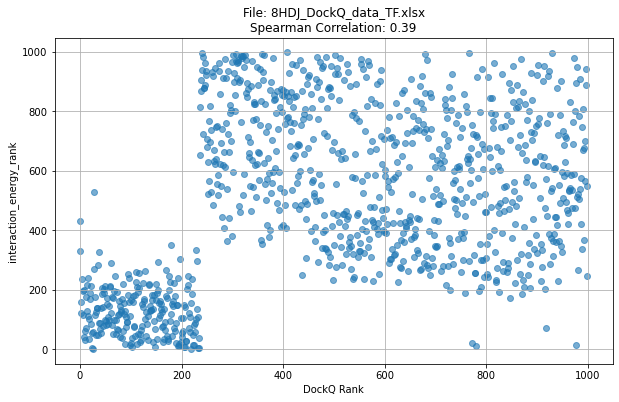

File: 8HDJ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.38897847346344333



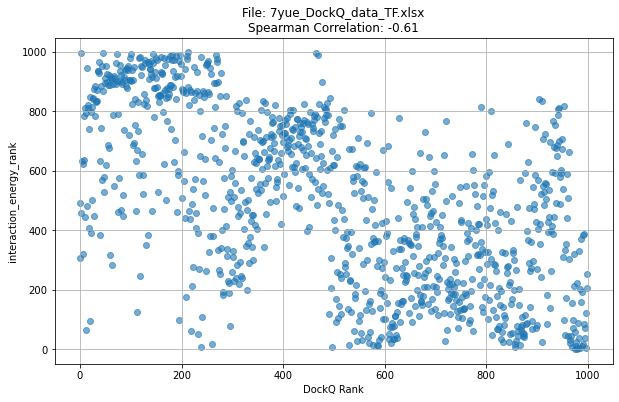

File: 7yue_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.6131142284569137



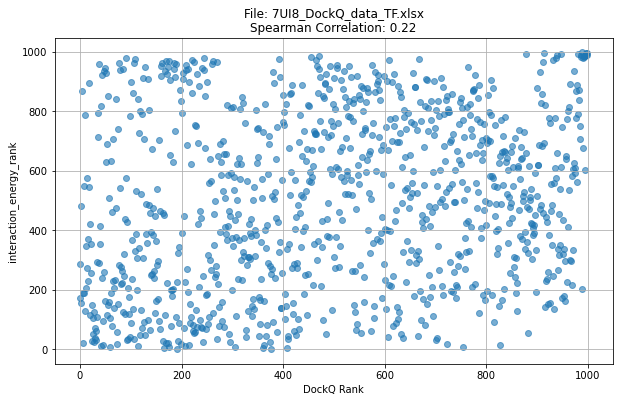

File: 7UI8_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.2223902098491276



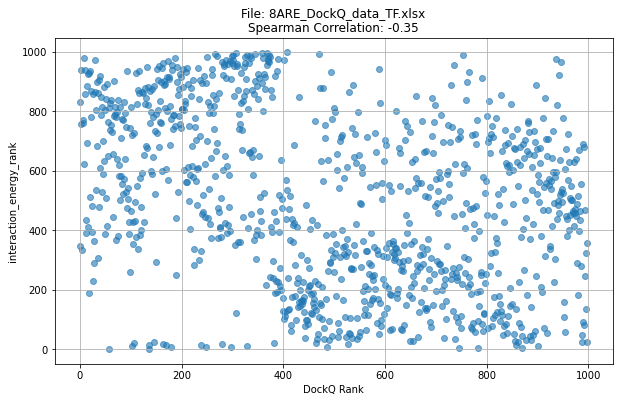

File: 8ARE_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3535509938796511



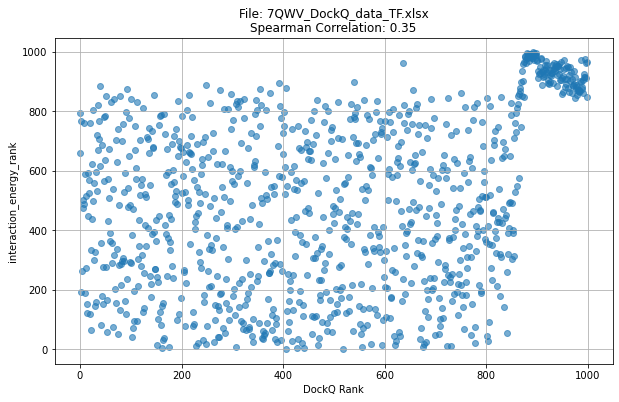

File: 7QWV_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3467436253889159



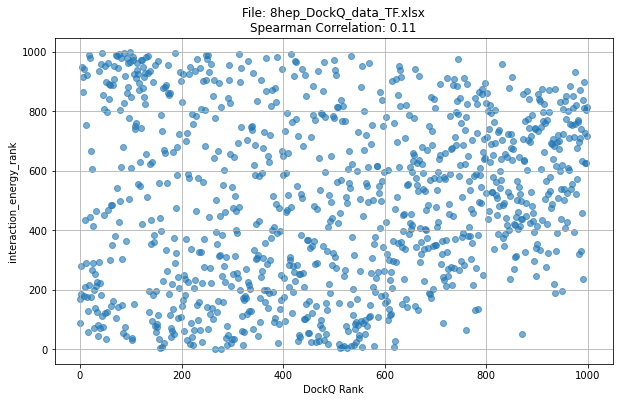

File: 8hep_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.11443049462287938

Summary of Spearman correlations saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TF_Spearman/correlations_Interaction_TF.xlsx


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from zipfile import BadZipFile

def process_excel_files(directory_path, output_directory):
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    correlations = []  # To store file names and their Spearman correlations
    
    for excel_file in excel_files:
        excel_file_path = os.path.join(directory_path, excel_file)
        
        try:
            xls = pd.ExcelFile(excel_file_path)
        except BadZipFile:
            print(f'Error: The file "{excel_file}" is not a valid Excel file or is corrupted.')
            continue
        except Exception as e:
            print(f'An unexpected error occurred while processing {excel_file}: {e}')
            continue
        
        if 'Foldx_Int' not in xls.sheet_names:
            print(f'The file "{excel_file}" does not contain a "Foldx_Int" sheet.')
            continue

        dockq_df = pd.read_excel(excel_file_path, sheet_name='Sheet')
        Foldx_df = pd.read_excel(excel_file_path, sheet_name='Foldx_Int')
        
        Foldx_rank_column = 'interaction_energy_rank'
        alpha_to_dockq_map = dockq_df.set_index('AlphaFold Rank')['DockQ Rank'].to_dict()
        Foldx_df['DockQ Rank'] = Foldx_df['alphafold rank'].map(alpha_to_dockq_map)
        
        filtered_Foldx_df = Foldx_df.dropna(subset=['DockQ Rank'])
        
        spearman_corr, _ = spearmanr(filtered_Foldx_df[Foldx_rank_column], filtered_Foldx_df['DockQ Rank'])
        
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_Foldx_df['DockQ Rank'], filtered_Foldx_df[Foldx_rank_column], alpha=0.6)
        plt.title(f'File: {excel_file}\nSpearman Correlation: {spearman_corr:.2f}')
        plt.xlabel('DockQ Rank')
        plt.ylabel('interaction_energy_rank')
        plt.grid(True)
        plt.show()

        # Append file name and Spearman correlation to the list
        correlations.append({'File Name': excel_file, 'Spearman Correlation': spearman_corr})
        print(f'File: {excel_file}\nSpearman Correlation Coefficient: {spearman_corr}\n')
    
    # Convert list to DataFrame
    correlations_df = pd.DataFrame(correlations)
    
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Path for the new Excel file
    output_file_path = os.path.join(output_directory, 'correlations_Interaction_TF.xlsx')
    
    # Save DataFrame to an Excel file
    correlations_df.to_excel(output_file_path, index=False)
    print(f'Summary of Spearman correlations saved to {output_file_path}')

# Example usage
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TF'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TF_Spearman'
process_excel_files(directory_path, output_directory)



In [10]:
import pandas as pd

def calculate_positive_negative_percentages_and_average(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path)
    
    # Count the total number of entries
    total_entries = len(data['Spearman Correlation'])
    
    # Count the number of positive and negative Foldx_Spearman Correlation values
    positive_count = data[data['Spearman Correlation'] > 0].shape[0]
    negative_count = data[data['Spearman Correlation'] < 0].shape[0]
    
    # Calculate percentages
    positive_percentage = (positive_count / total_entries) * 100
    negative_percentage = (negative_count / total_entries) * 100
    
    # Calculate the average of Foldx_Spearman Correlation values
    average_correlation = data['Spearman Correlation'].mean()
    
    return positive_percentage, negative_percentage, average_correlation

# Example usage
file_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TF_Spearman/correlations_Interaction_TF.xlsx'  # Replace with your actual file path
positive_percentage, negative_percentage, average_correlation = calculate_positive_negative_percentages_and_average(file_path)
print(f"Positive Foldx_Spearman Correlation: {positive_percentage:.2f}%")
print(f"Negative Foldx_Spearman Correlation: {negative_percentage:.2f}%")
print(f"Average Foldx_Spearman Correlation: {average_correlation:.2f}")


Positive Foldx_Spearman Correlation: 51.67%
Negative Foldx_Spearman Correlation: 48.33%
Average Foldx_Spearman Correlation: 0.04


In [11]:
import os
import pandas as pd

# Directory containing the Excel files
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TF'

# Initialize a list to store the results
results = []

# List all Excel files in the directory
excel_files = [file for file in os.listdir(directory_path) if file.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    xls = pd.ExcelFile(file_path)

    # Extract pdb_id from file name
    pdb_id = file_name.split('_')[0]

    # Load data from "Foldx" sheet
    foldx_df = pd.read_excel(file_path, sheet_name='Foldx_Int')
    structure_name_for_rank_zero = foldx_df[foldx_df['interaction_energy_rank'] == 0]['Unnamed: 0'].iloc[0].replace('_clean.pdb', '')

    # Load data from "Sheet" sheet
    sheet_df = pd.read_excel(file_path, sheet_name='Sheet')

    # Highest DockQ score
    highest_dockq_score = sheet_df['DockQ'].max()

    # DockQ score for the structure from Foldx
    highest_foldx_dockq_score = sheet_df[sheet_df['File Name'].str.contains(structure_name_for_rank_zero)]['DockQ'].max()

    # Calculate Loss
    score_Loss = highest_dockq_score - highest_foldx_dockq_score

    # Append results
    results.append([pdb_id, highest_dockq_score, highest_foldx_dockq_score, score_Loss])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['File Name', 'DockQ', 'Foldx/Interaction ranked', 'Loss'])

# Save the results into a new Excel file
output_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TF_Loss/Foldx_Interaction_TF.xlsx'
results_df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")




Results have been saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TF_Loss/Foldx_Interaction_TF.xlsx
